# Telecom Churn Prediction - Assignment Notebook

**Author:** Michael Thomas & Supriyo Roy

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [45]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [46]:
# #INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
# #(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv", index_col=None)
unseen = pd.read_csv("test.csv", index_col=None)
sample = pd.read_csv("sample.csv", index_col=None)
data_dict = pd.read_csv("data_dictionary.csv", index_col=None)


print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [47]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

# 2. Create X, y, Derive New Columns and then Train test split

Lets create X and y datasets and drop any column with only 1 unique value

### 2.1 Create X, y

In [48]:
data['circle_id'].unique()

array([109])

In [49]:
X = data.drop(['circle_id'], axis='columns').iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape


((69999, 170), (69999,))

In [50]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
69994    0
69995    0
69996    0
69997    0
69998    0
Name: churn_probability, Length: 69999, dtype: int64


In [51]:
print(X.columns)

Index(['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object', length=170)


In [52]:
X.head()

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
0   0             0.0             0.0             0.0            6/30/2014   
1   1             0.0             0.0             0.0            6/30/2014   
2   2             0.0             0.0             0.0            6/30/2014   
3   3             0.0             0.0             0.0            6/30/2014   
4   4             0.0             0.0             0.0            6/30/2014   

  last_date_of_month_7 last_date_of_month_8   arpu_6   arpu_7   arpu_8  ...  \
0            7/31/2014            8/31/2014   31.277   87.009    7.527  ...   
1            7/31/2014            8/31/2014    0.000  122.787   42.953  ...   
2            7/31/2014            8/31/2014   60.806  103.176    0.000  ...   
3            7/31/2014            8/31/2014  156.362  205.260  111.095  ...   
4            7/31/2014            8/31/2014  240.708  128.191  101.565  ...   

   sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0            0            0            0        NaN        NaN        NaN   
1            0            0            0        NaN        1.0        NaN   
2            0            0            0        NaN        NaN        NaN   
3            0            0            0        NaN        NaN        NaN   
4            0            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0  1958         0.0         0.0         0.0  
1   710         0.0         0.0         0.0  
2   882         0.0         0.0         0.0  
3   982         0.0         0.0         0.0  
4   647         0.0         0.0         0.0  

[5 rows x 170 columns]

### Removing columns - which have little/ no variation


In [53]:
# Dropping date columns, which don't appear to contribute to the results and are not numerical variables
columns_to_drop = [
    'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
    'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'
]

# Drop the specified columns from `data`
X = data.drop(columns=columns_to_drop, axis='columns').iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape


((69999, 162), (69999,))

In [54]:
# Dropping columns that only have a single value, and does not contribute to the results
threshold = 1

# Find columns with unique value counts below the threshold
few_unique_cols = {col: X[col].nunique() for col in X.columns if X[col].nunique() <= threshold}

# Display the columns and their unique counts
print(few_unique_cols)



{'circle_id': 1, 'loc_og_t2o_mou': 1, 'std_og_t2o_mou': 1, 'loc_ic_t2o_mou': 1, 'std_og_t2c_mou_6': 1, 'std_og_t2c_mou_7': 1, 'std_og_t2c_mou_8': 1, 'std_ic_t2o_mou_6': 1, 'std_ic_t2o_mou_7': 1, 'std_ic_t2o_mou_8': 1}


In [55]:
# Filter out columns with only one unique value
single_value_columns = [col for col in X.columns if X[col].nunique() == 1]

# Drop these columns from the DataFrame
X = X.drop(columns=single_value_columns)

# Display the shape of the updated DataFrame to confirm columns were dropped
X.shape


(69999, 152)

### Removing columns with more than 40% of missing data

<Axes: >

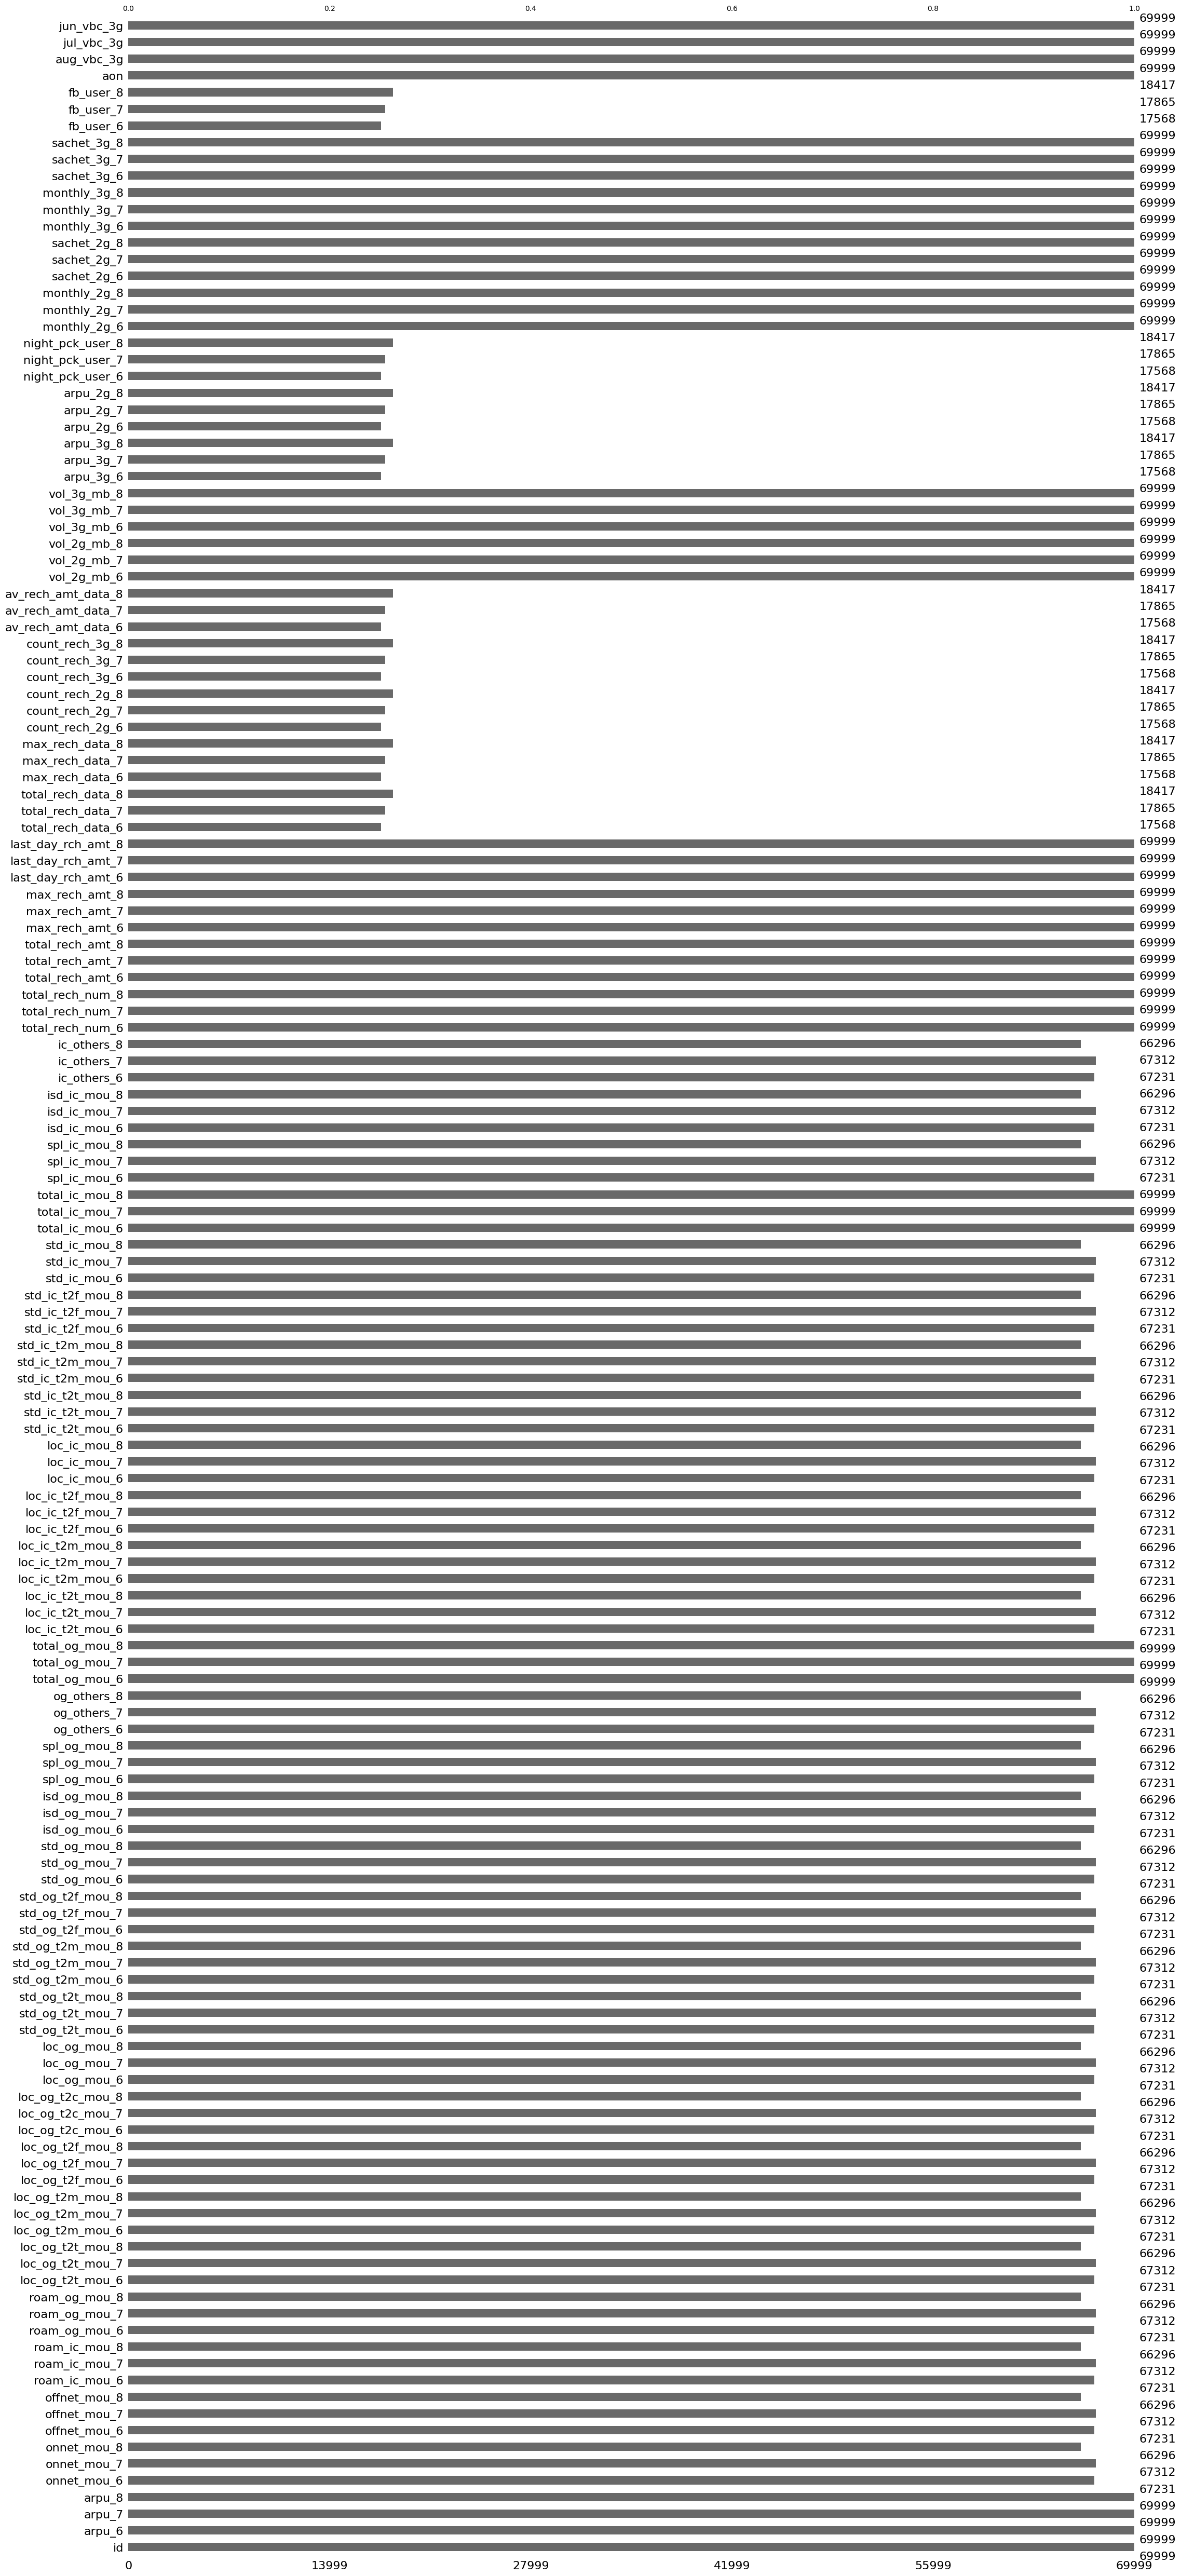

In [56]:
msno.bar(X)

In [57]:
missing_data_percent = 100*X.isnull().sum()/len(X)
missing_data_percent

id              0.000000
arpu_6          0.000000
arpu_7          0.000000
arpu_8          0.000000
onnet_mou_6     3.954342
                 ...    
fb_user_8      73.689624
aon             0.000000
aug_vbc_3g      0.000000
jul_vbc_3g      0.000000
jun_vbc_3g      0.000000
Length: 152, dtype: float64

In [58]:
# Identifying columns with less than 40% missing data
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=125)

In [59]:
# We will work only with columns that have less than 40% missing data
X_filtered = X[new_vars]


In [60]:
X_filtered.describe()


id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  69999.000000  69999.000000  69999.000000  69999.000000  67231.000000   
mean   34999.000000    283.134365    278.185912    278.858826    133.153275   
std    20207.115084    334.213918    344.366927    351.924315    299.963093   
min        0.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
25%    17499.500000     93.581000     86.714000     84.095000      7.410000   
50%    34999.000000    197.484000    191.588000    192.234000     34.110000   
75%    52498.500000    370.791000    365.369500    369.909000    119.390000   
max    69998.000000  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  67312.000000  66296.000000  67231.000000  67312.000000  66296.000000   
mean     133.894438    132.978257    198.874771    197.153383    196.543577   
std      311.277193    311.896596    316.818355    322.482226    324.089234   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.675000      6.410000     34.860000     32.240000     31.575000   
50%       32.280000     32.100000     96.480000     91.885000     91.800000   
75%      115.837500    115.060000    232.990000    227.630000    229.345000   
max     8157.780000  10752.560000   8362.360000   7043.980000  14007.340000   

       ...  monthly_3g_6  monthly_3g_7  monthly_3g_8   sachet_3g_6  \
count  ...  69999.000000  69999.000000  69999.000000  69999.000000   
mean   ...      0.075815      0.077730      0.081958      0.075344   
std    ...      0.358905      0.383189      0.381821      0.573003   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      9.000000     16.000000     16.000000     29.000000   

        sachet_3g_7   sachet_3g_8           aon    aug_vbc_3g    jul_vbc_3g  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean       0.081444      0.085487   1220.639709     68.108597     65.935830   
std        0.634547      0.680035    952.426321    269.328659    267.899034   
min        0.000000      0.000000    180.000000      0.000000      0.000000   
25%        0.000000      0.000000    468.000000      0.000000      0.000000   
50%        0.000000      0.000000    868.000000      0.000000      0.000000   
75%        0.000000      0.000000   1813.000000      0.000000      0.000000   
max       33.000000     41.000000   4337.000000  12916.220000   9165.600000   

        jun_vbc_3g  
count  69999.00000  
mean      60.07674  
std      257.22681  
min        0.00000  
25%        0.00000  
50%        0.00000  
75%        0.00000  
max    11166.21000  

[8 rows x 125 columns]

In [61]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 125)
Shape of y: (69999,)


## 2.2 Deriving New Feature Columns 

We noticed that while there are a series of colulmns related to the same type of variable, there is no variable which explains the percentage increase or decrese over that time period. Consequently we are proposing to add a few new columns for 

- Average change in revenue per user across months 6,7,8 (arpu_6, arpu_7, arpu_8)
- Average change in all kinds of calls within the same operator network for months 6,7,8 (onnet_mou_6, onnet_mou_7, onnet_mou_8)
- Average change in all kinds of calls outside the same operator network for months 6,7,8 (offnet_mou_6, offnet_mou_7, offnet_mou_8)




### Deriving new columns for average changes in revenue across months 6,7,8 (arpu_6, arpu_7, arpu_8)
Calculate the change in revenue between months:

From month 6 to month 7 (arpu_7 - arpu_6)
From month 7 to month 8 (arpu_8 - arpu_7)
Take the average of these two changes to create a new derived col


In [62]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 125)
Shape of y: (69999,)


In [63]:
# Calculate the average absolute change in revenue
X_filtered['avg_absolute_change_revenue'] = (
    (X_filtered['arpu_7'] - X_filtered['arpu_6']) +
    (X_filtered['arpu_8'] - X_filtered['arpu_7'])
) / 2

# Calculate the average percentage change in revenue
X_filtered['avg_percentage_change_revenue'] = (
    ((X_filtered['arpu_7'] - X_filtered['arpu_6']) / X_filtered['arpu_6']) +
    ((X_filtered['arpu_8'] - X_filtered['arpu_7']) / X_filtered['arpu_7'])
) / 2


In [64]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 127)
Shape of y: (69999,)


In [65]:
X_filtered[['avg_absolute_change_revenue', 'avg_percentage_change_revenue']].describe()


avg_absolute_change_revenue  avg_percentage_change_revenue
count                 69999.000000                   6.837700e+04
mean                     -2.137769                            NaN
std                     145.127104                            NaN
min                   -5752.754000                           -inf
25%                     -51.805750                  -1.427237e-01
50%                      -0.732000                   9.301916e-02
75%                      47.756250                   5.329413e-01
max                    6804.332000                            inf

In [66]:
# Confirming that the number of columns have increased from 125 to 127
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 127)
Shape of y: (69999,)


In [67]:
# Compute the mean and describe
print(X_filtered['avg_percentage_change_revenue'].mean())
print(X_filtered[['avg_absolute_change_revenue', 'avg_percentage_change_revenue']].describe())


nan
       avg_absolute_change_revenue  avg_percentage_change_revenue
count                 69999.000000                   6.837700e+04
mean                     -2.137769                            NaN
std                     145.127104                            NaN
min                   -5752.754000                           -inf
25%                     -51.805750                  -1.427237e-01
50%                      -0.732000                   9.301916e-02
75%                      47.756250                   5.329413e-01
max                    6804.332000                            inf


In [68]:
# Replace infinity with NaN
X_filtered['avg_percentage_change_revenue'] = X_filtered['avg_percentage_change_revenue'].replace([np.inf, -np.inf], np.nan)

# Calculate the median of the column
median_value = X_filtered['avg_percentage_change_revenue'].median()

# Replace NaN with the median value
X_filtered['avg_percentage_change_revenue'] = X_filtered['avg_percentage_change_revenue'].fillna(median_value)


### Deriving a new column for average change in all kinds of calls within the same operator network 

In [69]:
X_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']].describe()

onnet_mou_6   onnet_mou_7   onnet_mou_8
count  67231.000000  67312.000000  66296.000000
mean     133.153275    133.894438    132.978257
std      299.963093    311.277193    311.896596
min        0.000000      0.000000      0.000000
25%        7.410000      6.675000      6.410000
50%       34.110000     32.280000     32.100000
75%      119.390000    115.837500    115.060000
max     7376.710000   8157.780000  10752.560000

In [70]:
# Replace missing values with 0 or any other appropriate default
X_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']] = \
    X_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']].fillna(0)


In [71]:
# Calculate the average change in on-net minutes of usage
X_filtered['avg_change_onnet_mou'] = (
    (X_filtered['onnet_mou_7'] - X_filtered['onnet_mou_6']) +
    (X_filtered['onnet_mou_8'] - X_filtered['onnet_mou_7'])
) / 2


In [72]:
print(X_filtered['avg_change_onnet_mou'].describe())


count    69999.000000
mean        -0.972166
std        134.971400
min      -3411.600000
25%        -12.680000
50%          0.000000
75%         10.235000
max       3395.190000
Name: avg_change_onnet_mou, dtype: float64


In [73]:
# Testing that the columns have increased from 127 to 128
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 128)
Shape of y: (69999,)


### Deriving a new column for average change in all kinds of calls outside the operator network 

In [74]:
X_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']].describe()

offnet_mou_6  offnet_mou_7  offnet_mou_8
count  67231.000000  67312.000000  66296.000000
mean     198.874771    197.153383    196.543577
std      316.818355    322.482226    324.089234
min        0.000000      0.000000      0.000000
25%       34.860000     32.240000     31.575000
50%       96.480000     91.885000     91.800000
75%      232.990000    227.630000    229.345000
max     8362.360000   7043.980000  14007.340000

In [75]:
# Calculate the average change in off-net minutes of usage
X_filtered['avg_change_offnet_mou'] = (
    (X_filtered['offnet_mou_7'] - X_filtered['offnet_mou_6']) +
    (X_filtered['offnet_mou_8'] - X_filtered['offnet_mou_7'])
) / 2


In [76]:
# Replace missing values with 0 or another appropriate value
X_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']] = \
    X_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']].fillna(0)


In [77]:
print(X_filtered['avg_change_offnet_mou'].describe())


count    63842.000000
mean        -1.165819
std        141.760274
min      -4166.000000
25%        -27.360000
50%         -0.520000
75%         23.388750
max       6887.525000
Name: avg_change_offnet_mou, dtype: float64


In [78]:
# Testing that the number of columns have increased from 128 to 129
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 129)
Shape of y: (69999,)


## 2.3 Train Test Split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((55999, 129), (14000, 129), (55999,), (14000,))

In [80]:
X_train.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
60564  60564  140.092  255.518  174.689         8.93        23.53   
9704    9704  252.369  257.830   86.027       293.64       186.71   
63089  63089  416.623  397.056  381.633       429.66       480.31   
9347    9347  333.276  293.960  302.107        18.33        26.01   
17082  17082  306.193  309.776  377.208       148.41       125.73   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
60564         3.44        114.01        283.11        240.63  ...   
9704         48.68         60.79        315.74        142.13  ...   
63089       395.69        382.14        283.83        373.06  ...   
9347         22.08        527.23        539.63        386.93  ...   
17082        94.29        240.58        183.36        308.33  ...   

       sachet_3g_7  sachet_3g_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
60564            0            0   263         0.0         0.0         0.0   
9704             0            0   678         0.0         0.0         0.0   
63089            0            0  1040         0.0         0.0         0.0   
9347             0            0   989         0.0         0.0         0.0   
17082            0            0  1632         0.0         0.0         0.0   

       avg_absolute_change_revenue  avg_percentage_change_revenue  \
60564                      17.2985                       0.253798   
9704                      -83.1710                      -0.322352   
63089                     -17.4950                      -0.042905   
9347                      -15.5845                      -0.045127   
17082                      35.5075                       0.114691   

       avg_change_onnet_mou  avg_change_offnet_mou  
60564                -2.745                 63.310  
9704               -122.480                 40.670  
63089               -16.985                 -4.540  
9347                  1.875                -70.150  
17082               -27.060                 33.875  

[5 rows x 129 columns]

# 3. Handling Missing data

## 3.1 Handling Missing data - Training Set

In [81]:
print(X_train.shape)
print(y_train.shape)


(55999, 129)
(55999,)


In [82]:
# Display the data types of each column
print(X_train.dtypes)


id                                 int64
arpu_6                           float64
arpu_7                           float64
arpu_8                           float64
onnet_mou_6                      float64
                                  ...   
jun_vbc_3g                       float64
avg_absolute_change_revenue      float64
avg_percentage_change_revenue    float64
avg_change_onnet_mou             float64
avg_change_offnet_mou            float64
Length: 129, dtype: object


In [83]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_train.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [84]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_train_filtered = X_train.apply(pd.to_numeric, errors='coerce')

In [86]:
print(X_train_filtered.shape)
print(y_train.shape)


(55999, 129)
(55999,)


<Axes: >

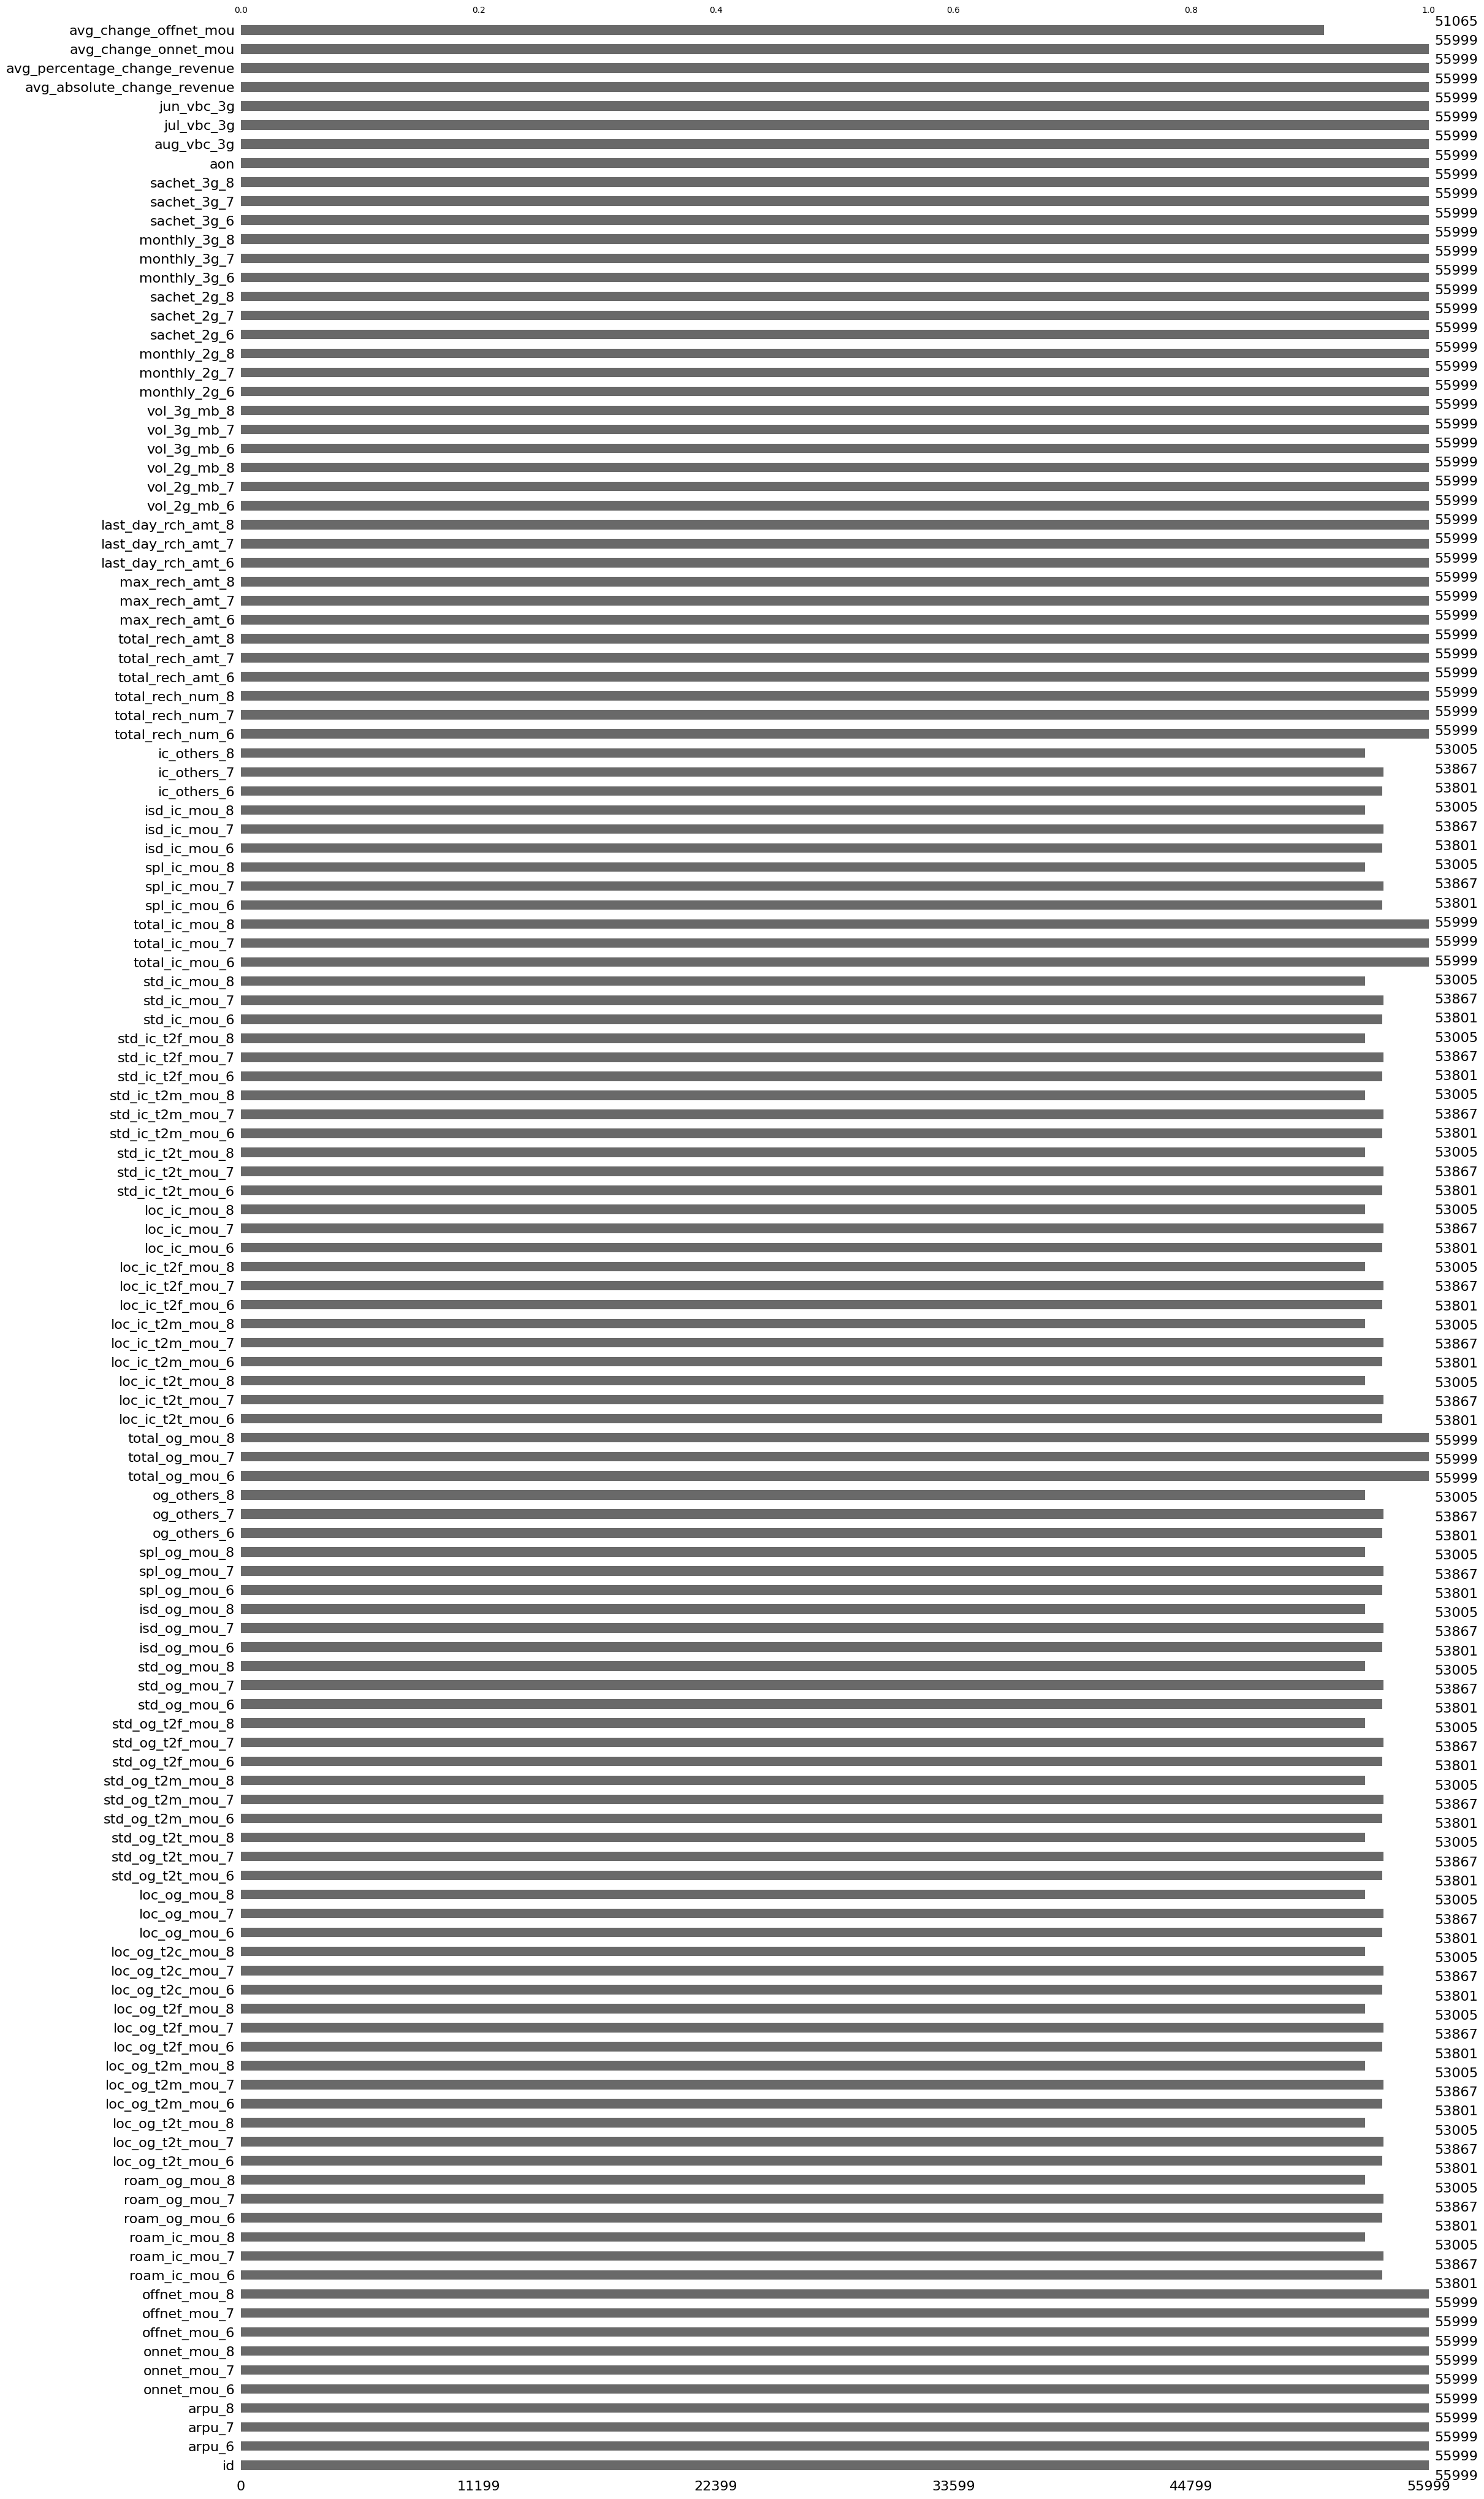

In [87]:
msno.bar(X_train)

In [88]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_

In [89]:
# Check for infinite values
print(np.isinf(X_train_filtered).sum())

# Check for very large values
print((X_train_filtered.abs() > 1e308).sum())


id                               0
arpu_6                           0
arpu_7                           0
arpu_8                           0
onnet_mou_6                      0
                                ..
jun_vbc_3g                       0
avg_absolute_change_revenue      0
avg_percentage_change_revenue    0
avg_change_onnet_mou             0
avg_change_offnet_mou            0
Length: 129, dtype: int64
id                               0
arpu_6                           0
arpu_7                           0
arpu_8                           0
onnet_mou_6                      0
                                ..
jun_vbc_3g                       0
avg_absolute_change_revenue      0
avg_percentage_change_revenue    0
avg_change_onnet_mou             0
avg_change_offnet_mou            0
Length: 129, dtype: int64


In [90]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

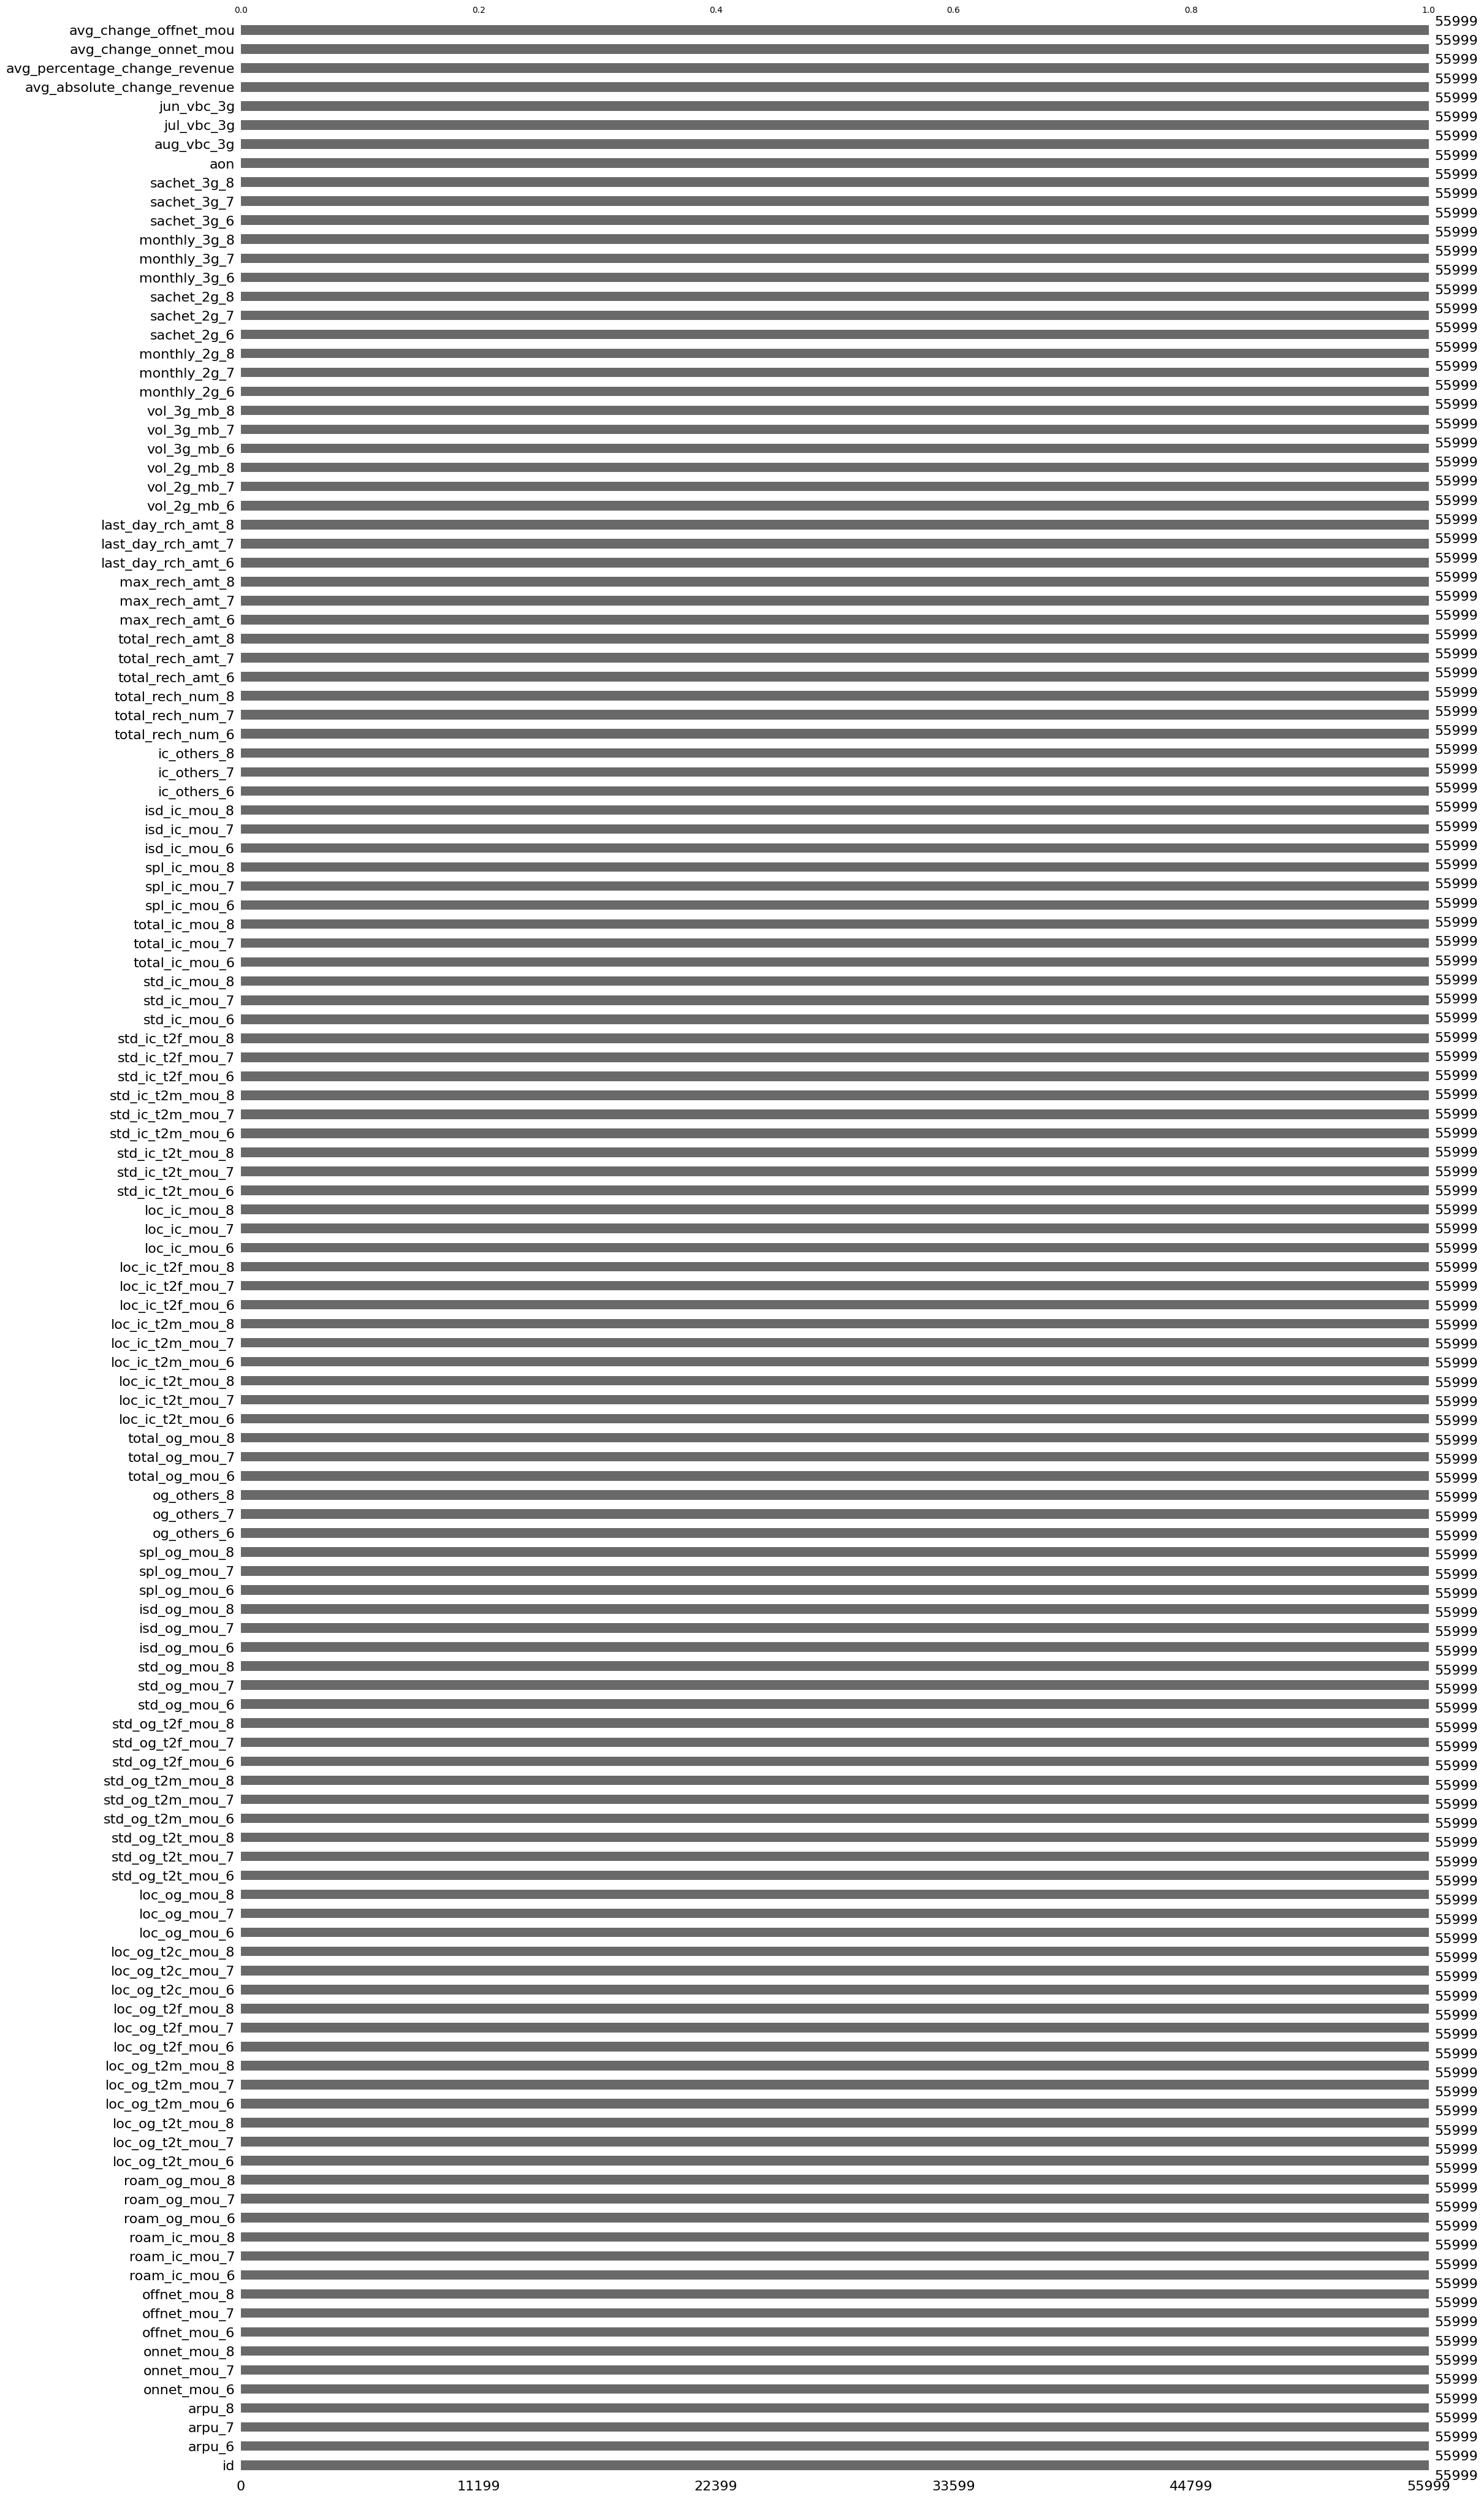

In [93]:
# Visually inspecting columns to ensure that missing values are filled
msno.bar(X_train_filtered)

In [96]:
# Checking consistency in the dimensions of X_train_filtered and y_train
print(X_train_filtered.shape)
print(y_train.shape)


(55999, 129)
(55999,)


In [97]:
X_train_filtered.describe()


id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean   35093.449401    283.747271    279.033738    279.646809    128.166923   
std    20201.862171    341.672717    355.047744    362.635629    294.882932   
min        1.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
25%    17617.500000     94.120500     86.714500     84.150000      5.560000   
50%    35152.000000    197.711000    192.576000    193.349000     31.110000   
75%    52611.500000    371.058000    366.107500    370.576500    113.740000   
max    69998.000000  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     129.455650    126.457695    191.549851    189.862429    186.711714   
std      307.296785    305.115878    312.051209    318.123248    322.250817   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.930000      4.130000     28.840000     26.840000     23.610000   
50%       29.430000     27.960000     89.940000     85.730000     82.860000   
75%      109.370000    106.495000    224.195000    219.180000    216.535000   
max     8157.780000  10752.560000   6712.810000   7043.980000  14007.340000   

       ...   sachet_3g_7   sachet_3g_8           aon    aug_vbc_3g  \
count  ...  55999.000000  55999.000000  55999.000000  55999.000000   
mean   ...      0.081019      0.085484   1218.774853     67.324651   
std    ...      0.624989      0.664679    951.216462    260.603044   
min    ...      0.000000      0.000000    180.000000      0.000000   
25%    ...      0.000000      0.000000    468.000000      0.000000   
50%    ...      0.000000      0.000000    867.000000      0.000000   
75%    ...      0.000000      0.000000   1805.000000      0.000000   
max    ...     33.000000     38.000000   4337.000000   8214.950000   

         jul_vbc_3g    jun_vbc_3g  avg_absolute_change_revenue  \
count  55999.000000  55999.000000                 55999.000000   
mean      65.489924     60.463744                    -2.050231   
std      261.847341    254.768944                   147.099447   
min        0.000000      0.000000                 -5752.754000   
25%        0.000000      0.000000                   -51.957500   
50%        0.000000      0.000000                    -0.867500   
75%        0.000000      0.000000                    47.839500   
max     8716.150000   7581.250000                  6804.332000   

       avg_percentage_change_revenue  avg_change_onnet_mou  \
count                   55999.000000          55999.000000   
mean                       10.306423             -0.854614   
std                       296.356861            136.056668   
min                     -7037.778051          -3411.600000   
25%                        -0.134644            -12.790000   
50%                         0.072072              0.000000   
75%                         0.387536             10.310000   
max                     30174.501095           3383.840000   

       avg_change_offnet_mou  
count           55999.000000  
mean               -0.886953  
std               135.623800  
min             -2236.875000  
25%               -23.280000  
50%                 0.000000  
75%                19.550000  
max              6887.525000  

[8 rows x 129 columns]

## 3.2 Handling Missing data - Test Set

In [98]:
# Display the data types of each column
print(X_test.dtypes)

id                                 int64
arpu_6                           float64
arpu_7                           float64
arpu_8                           float64
onnet_mou_6                      float64
                                  ...   
jun_vbc_3g                       float64
avg_absolute_change_revenue      float64
avg_percentage_change_revenue    float64
avg_change_onnet_mou             float64
avg_change_offnet_mou            float64
Length: 129, dtype: object


In [99]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_test.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [100]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_test_filtered = X_test.apply(pd.to_numeric, errors='coerce')

<Axes: >

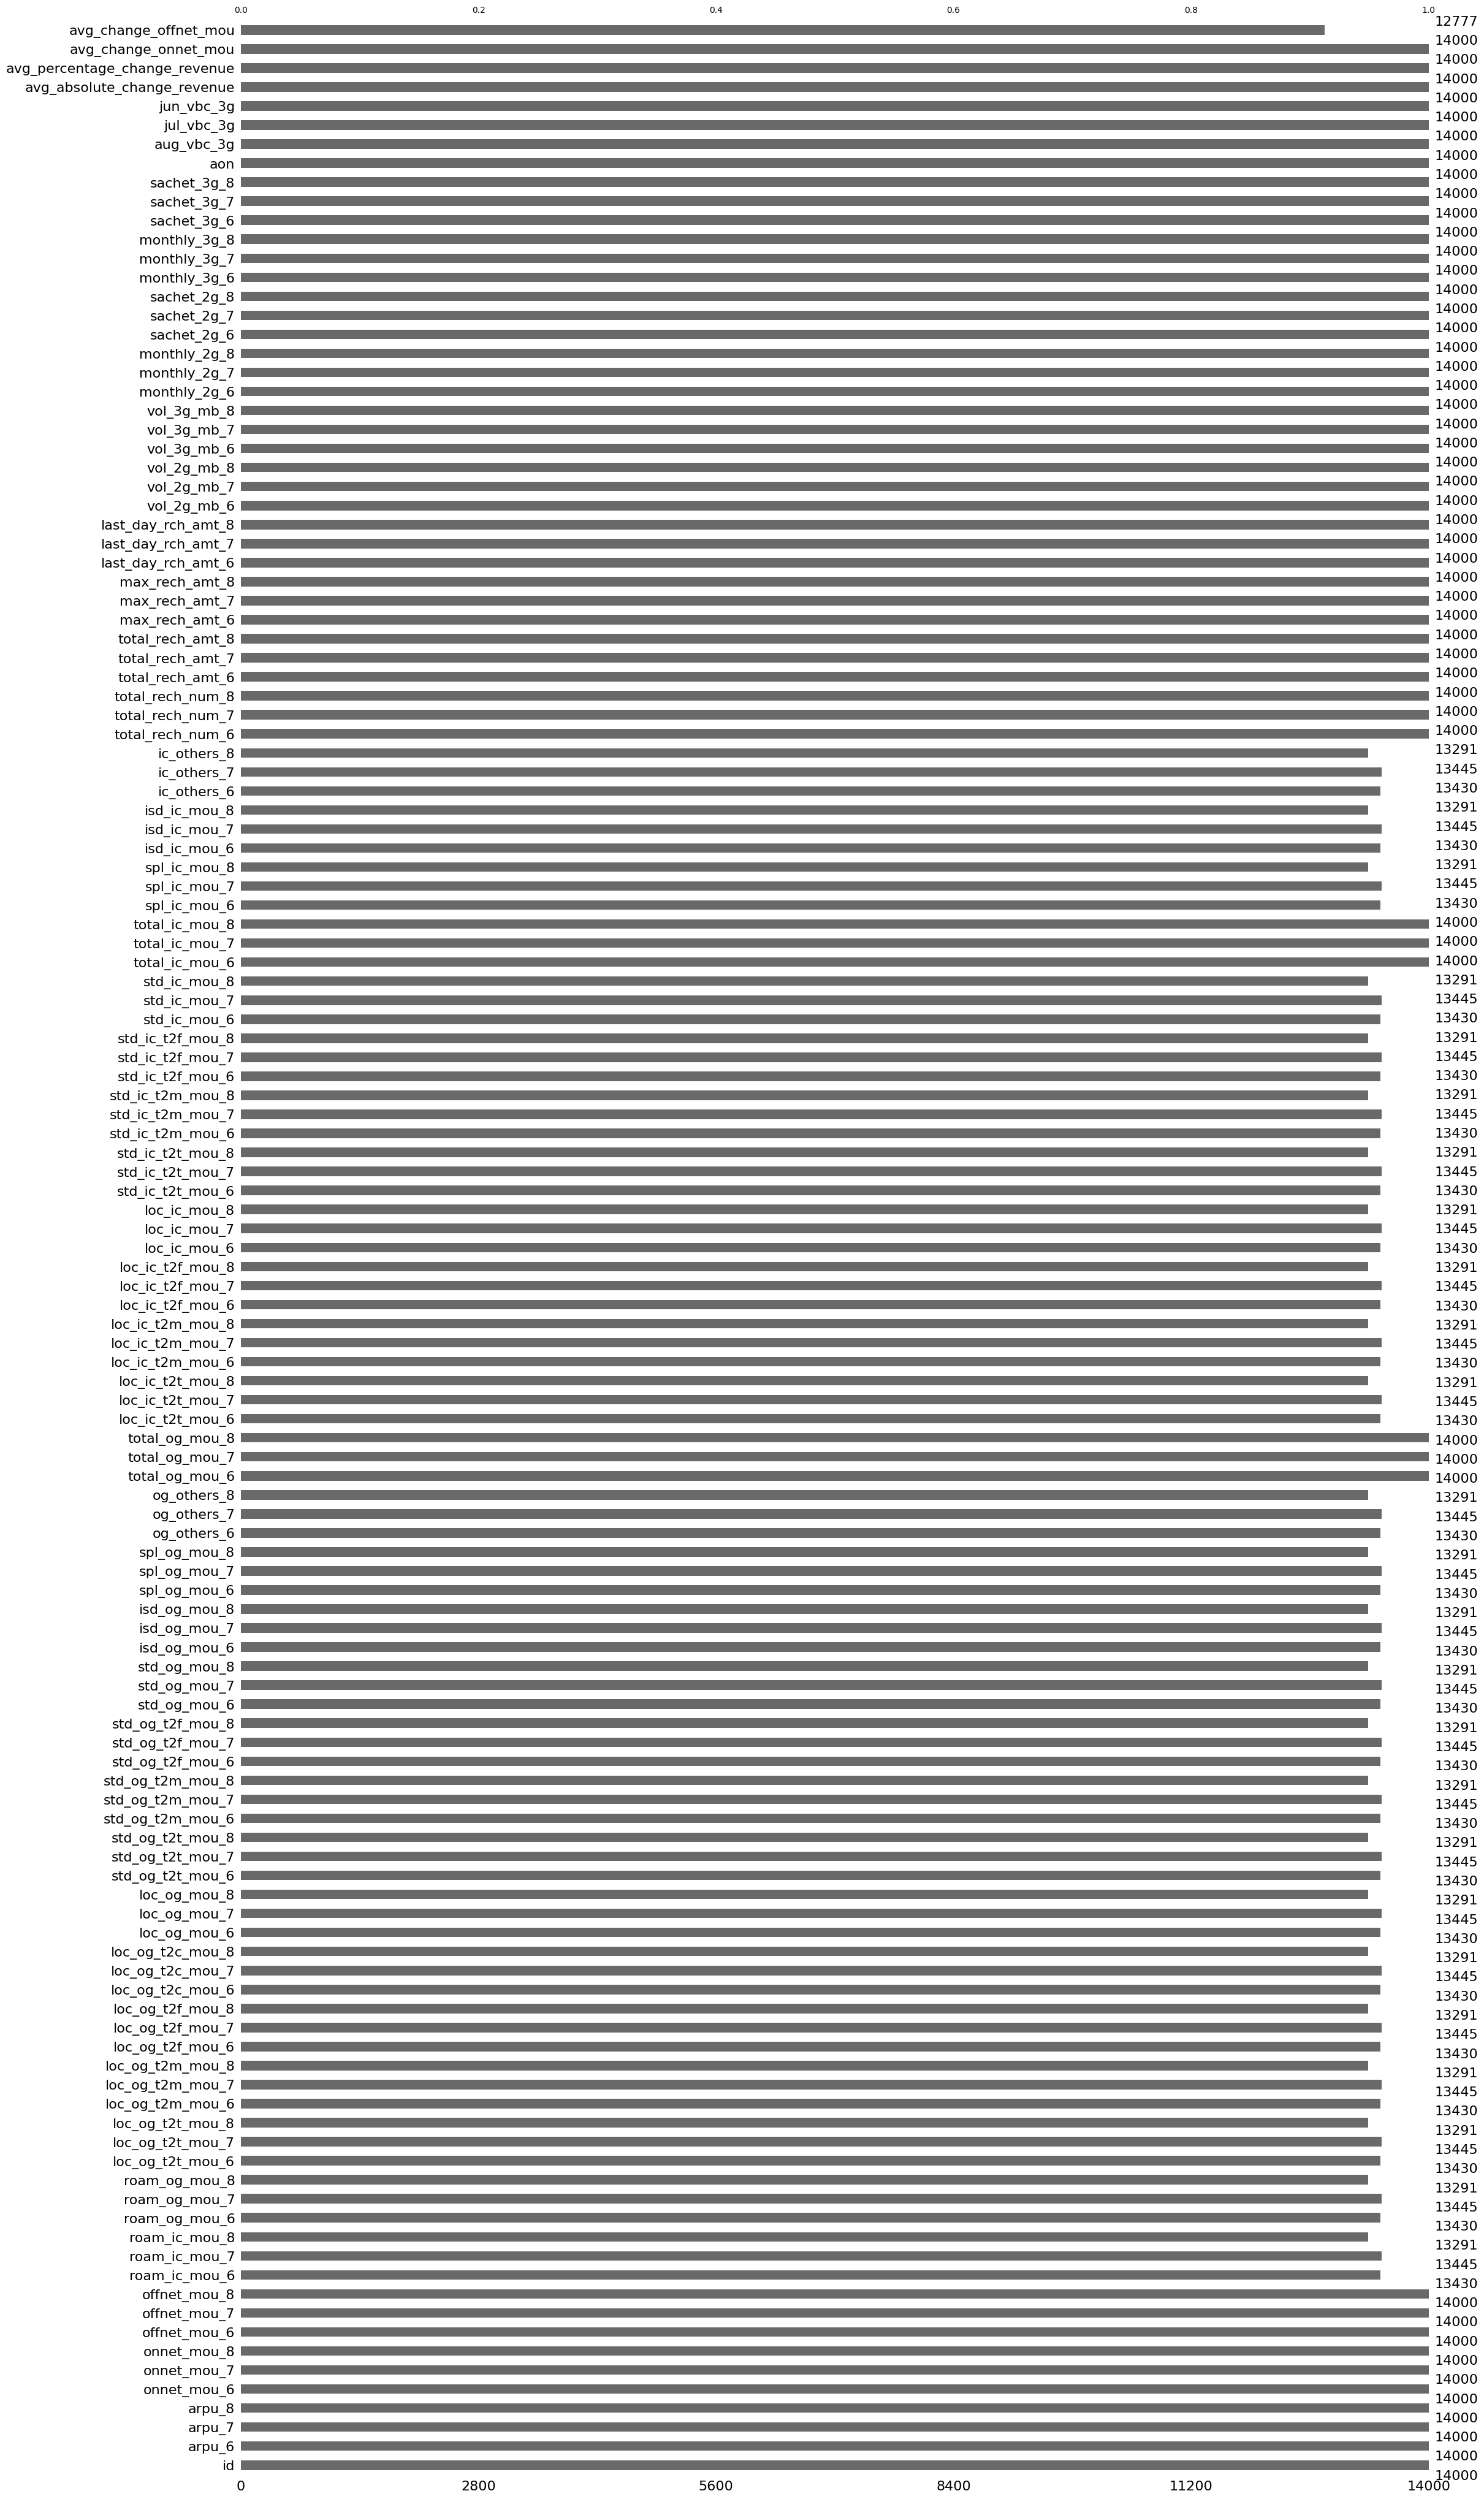

In [101]:
msno.bar(X_test)

In [102]:
missing_data_percent = X_test_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_

In [103]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_test_filtered[impute_cols] = imp.fit_transform(X_test_filtered[impute_cols])

<Axes: >

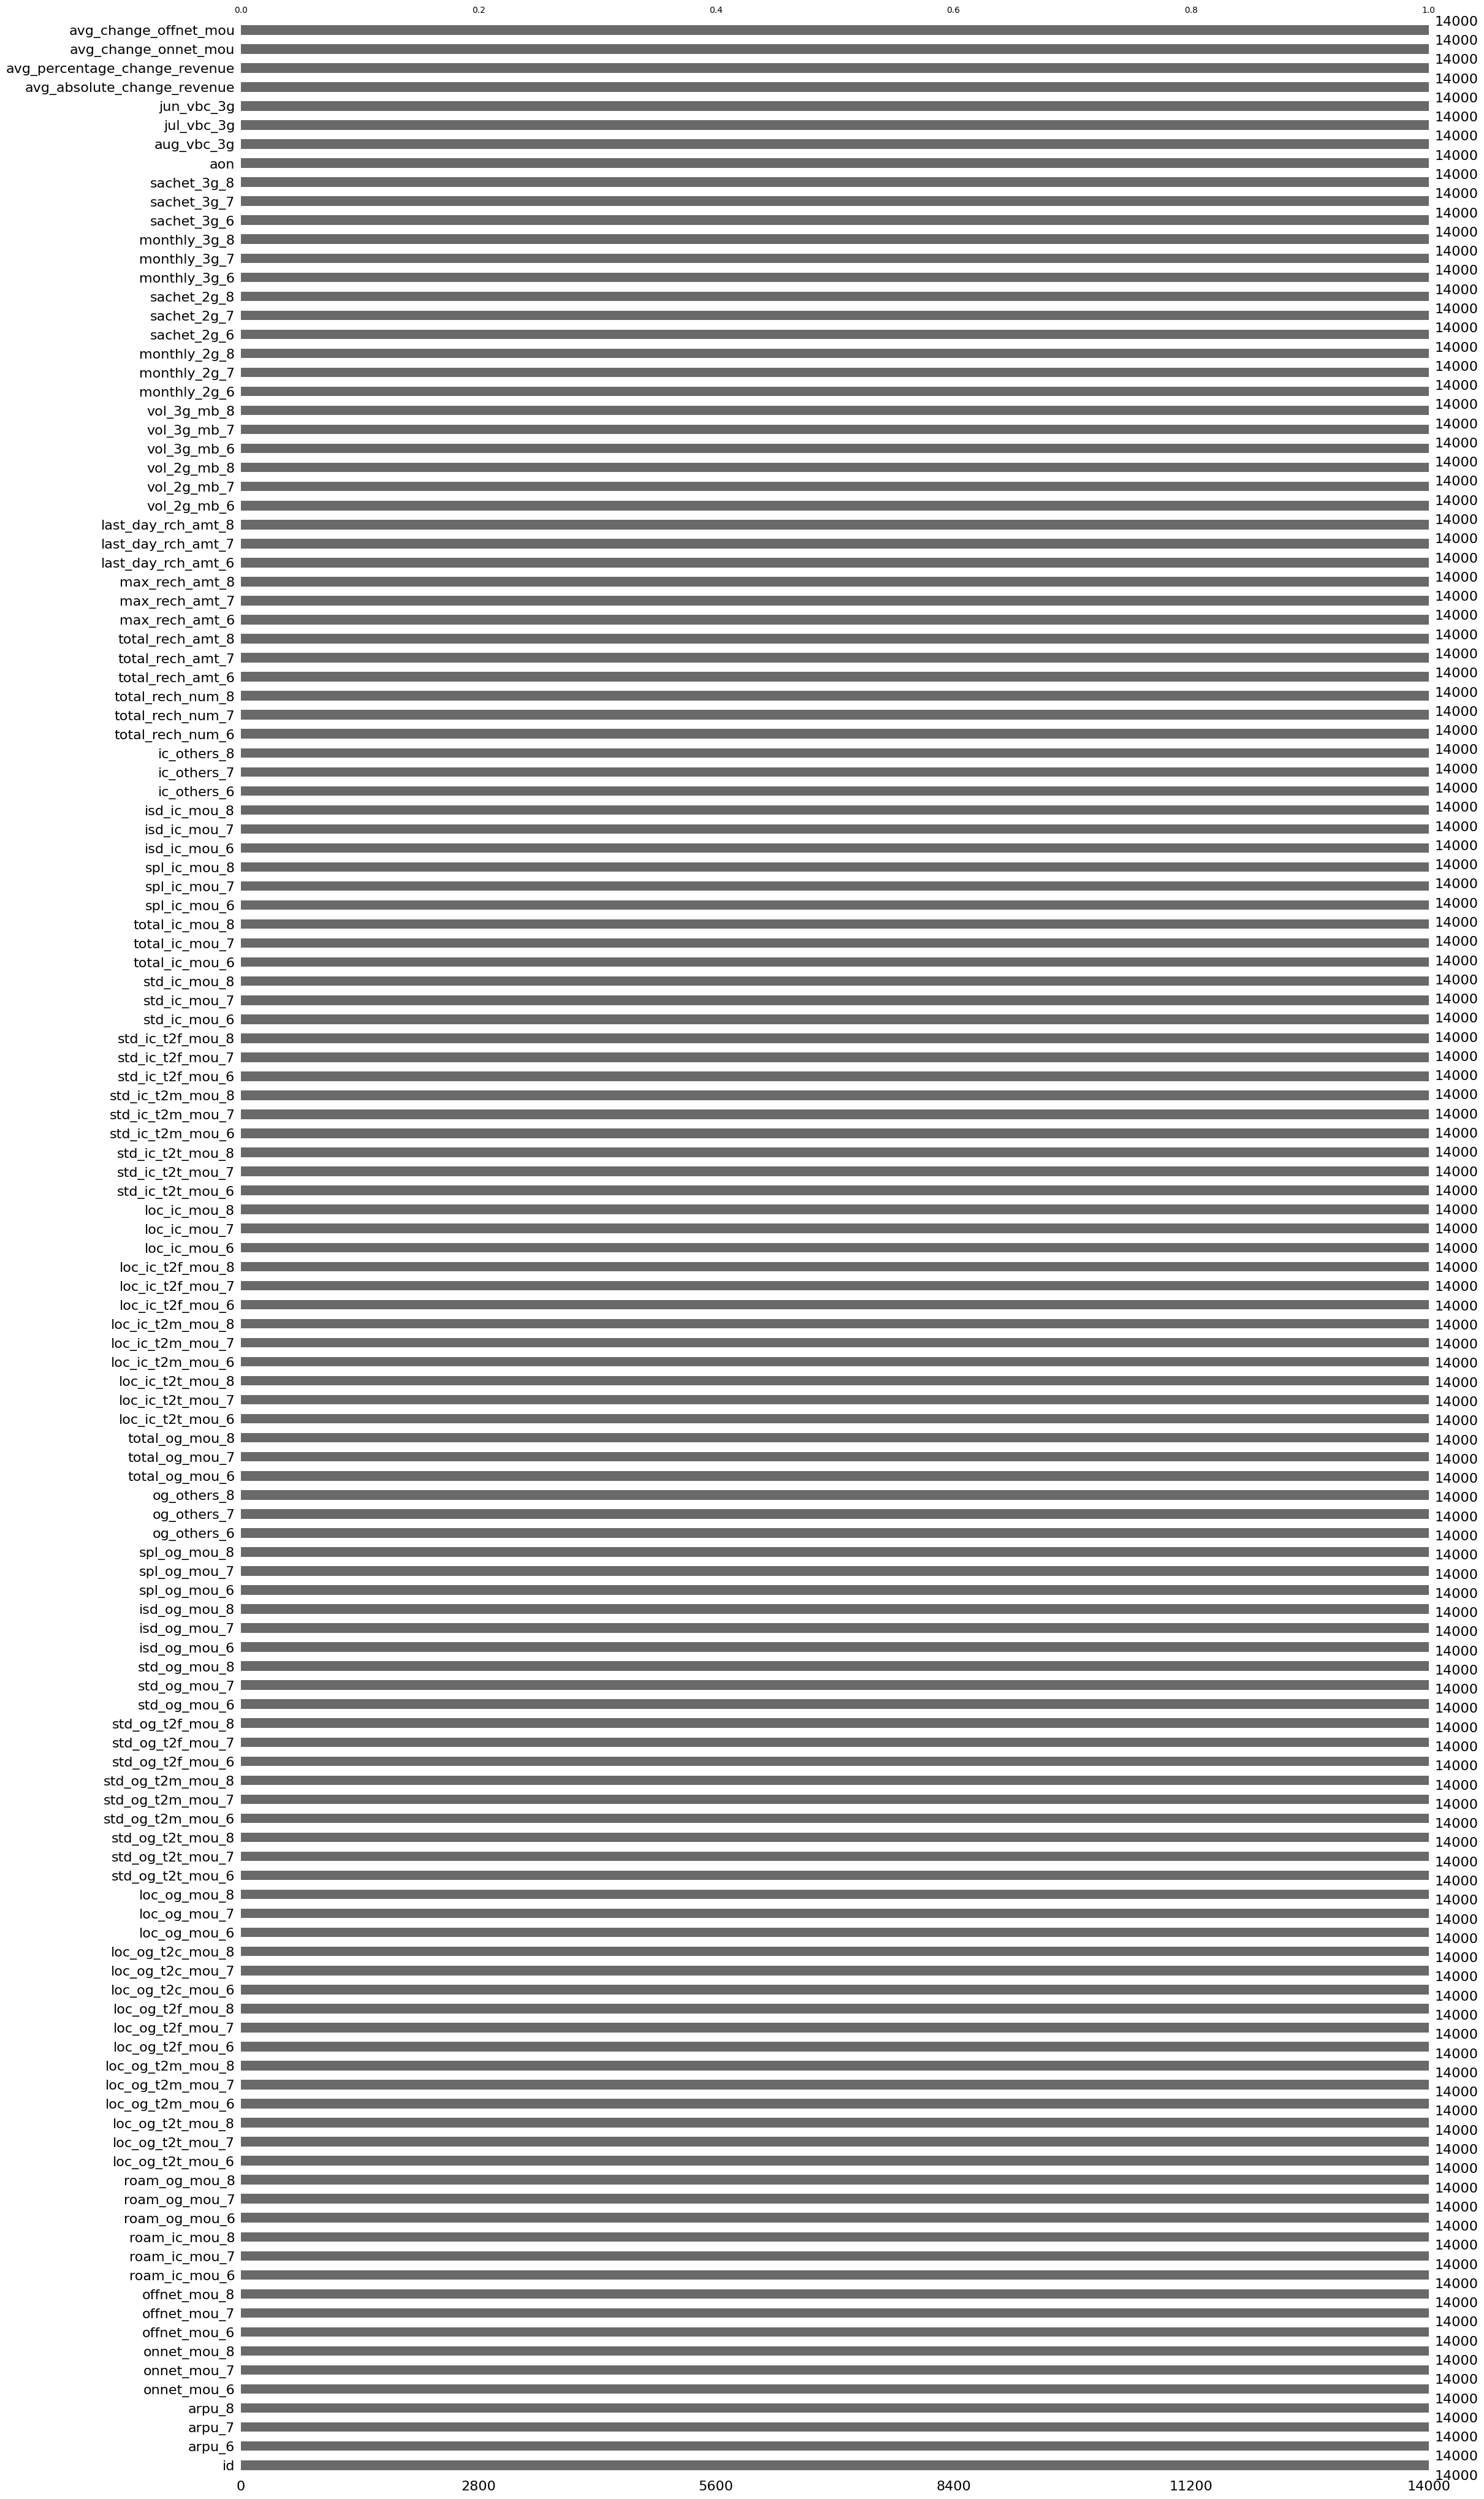

In [105]:
# Visually inspect X_test_filtered to check that missing values have been filled
msno.bar(X_test_filtered)

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

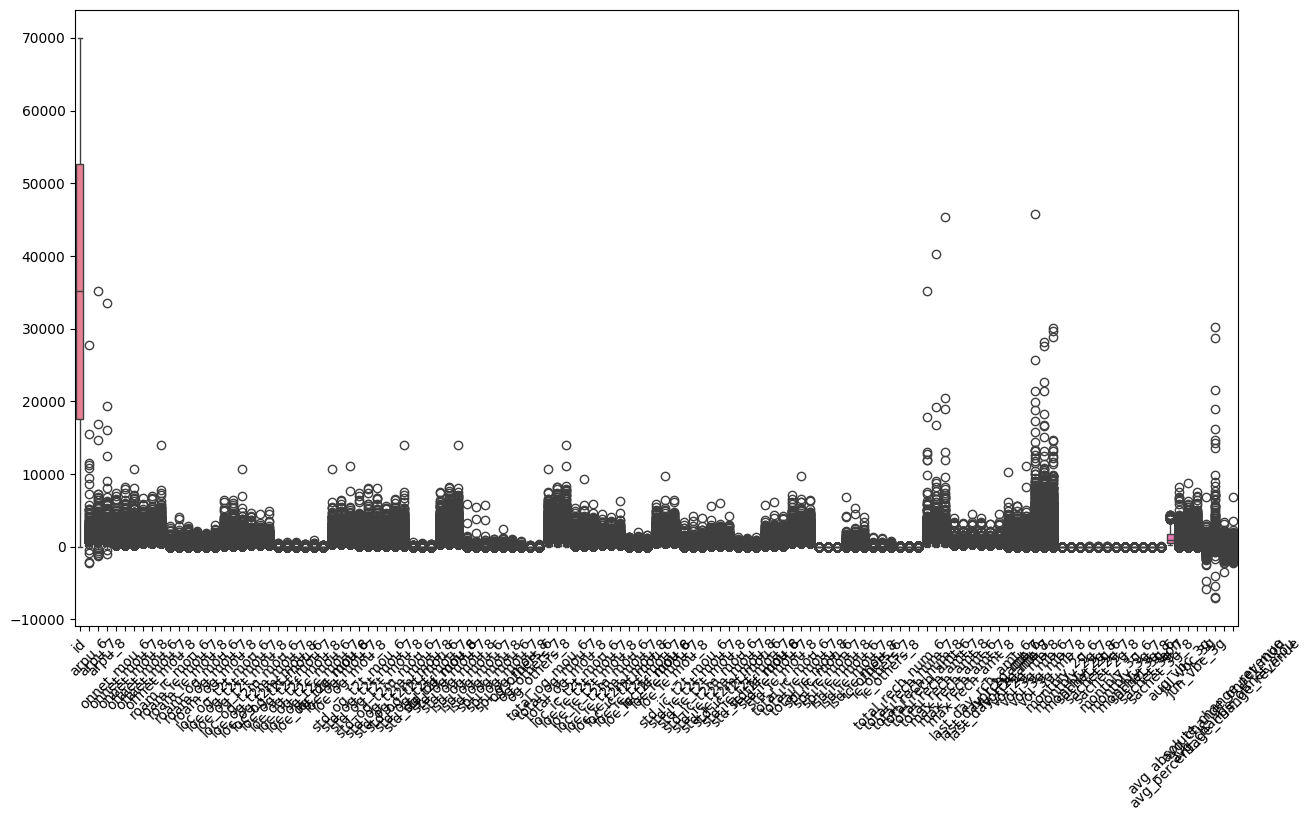

In [106]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

In [110]:
# From this graph it is possible to see that there are a significant amount of columns with outliers that need to be standardised later in this section
# We will now look at some of the key variables

### Analysing changes in average revenue per user

In [ ]:
# Average revenue per user can help to identify high-value customers 

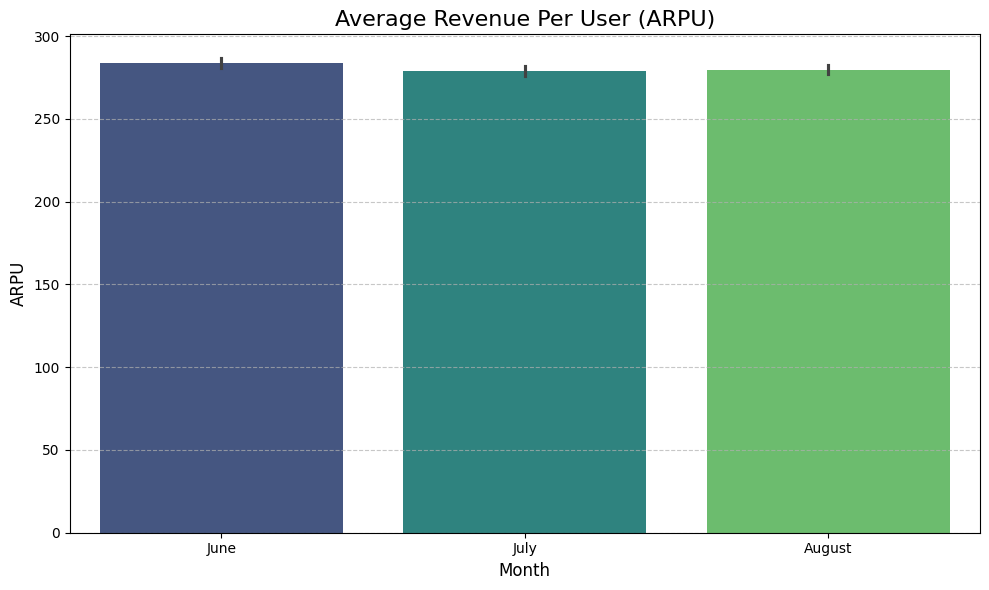

In [111]:
# Visualising Average Revenue per user
# Columns for ARPU
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
months = ['June', 'July', 'August']

# Prepare the DataFrame for plotting
arpu_data = X_train_filtered[arpu_cols].copy()
arpu_data.columns = months  # Rename columns for months

# Melt the DataFrame to long format
arpu_long = arpu_data.melt(var_name='Month', value_name='ARPU')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=arpu_long, x='Month', y='ARPU', palette='viridis')

# Customize the plot
plt.title('Average Revenue Per User (ARPU)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('ARPU', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()





In [112]:
# It appears that average revenue per customer is relatively stable month on month

### Visualising total outgoing minutes of usage

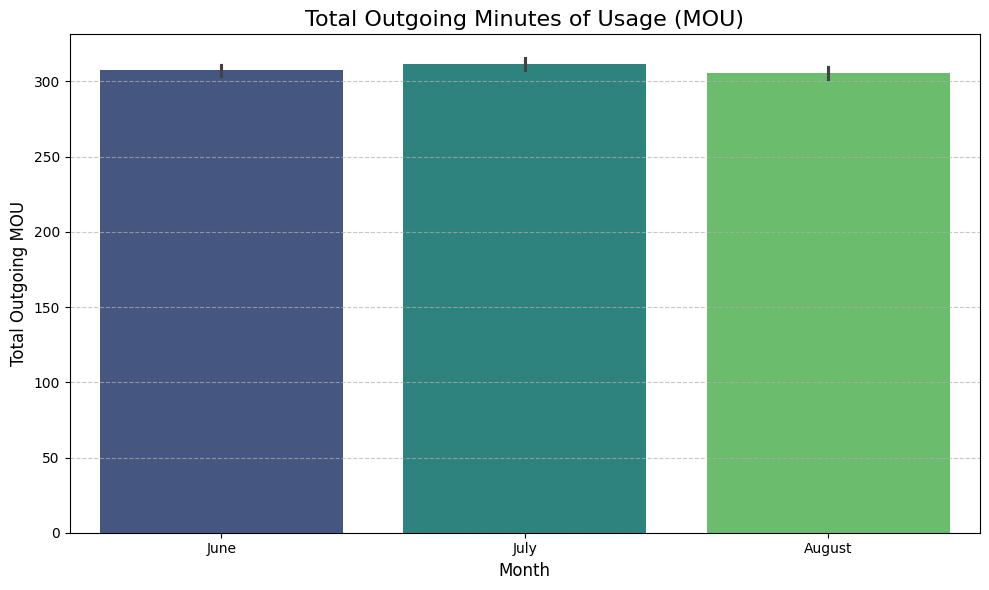

In [113]:
# Columns for total outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
months = ['June', 'July', 'August']

# Prepare the DataFrame for plotting
mou_data = X_train_filtered[total_og_mou_cols].copy()
mou_data.columns = months  # Rename columns for months

# Melt the DataFrame to long format
mou_long = mou_data.melt(var_name='Month', value_name='Total Outgoing MOU')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=mou_long, x='Month', y='Total Outgoing MOU', palette='viridis')

# Customize the plot
plt.title('Total Outgoing Minutes of Usage (MOU)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Outgoing MOU', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Outgoing minutes of usage appears relatively stable

### Visualizing calls made outside the operator network

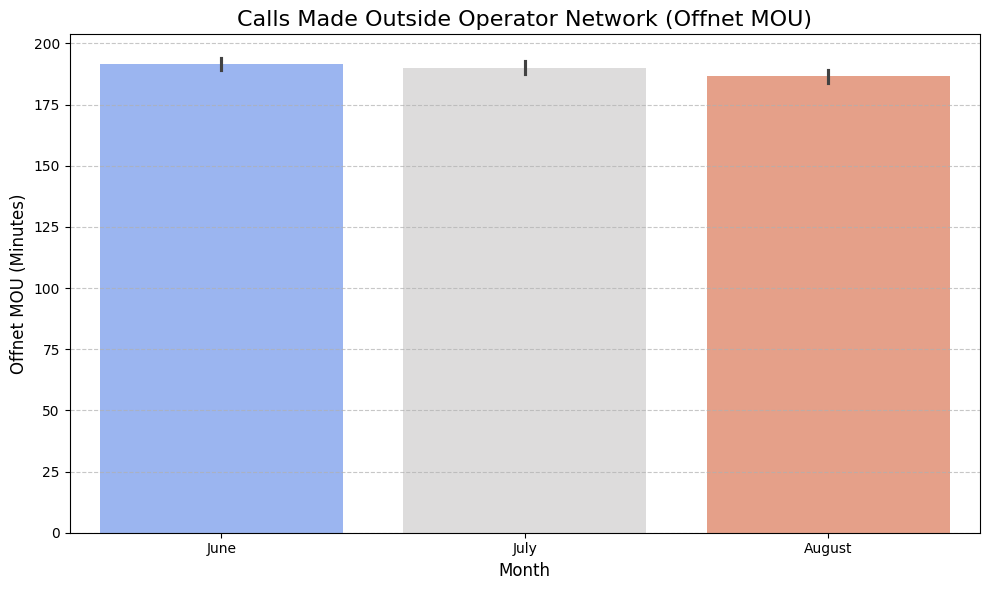

In [114]:
# Columns for calls made outside the operator network
offnet_mou_cols = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
months = ['June', 'July', 'August']

# Prepare the DataFrame for plotting
offnet_data = X_train_filtered[offnet_mou_cols].copy()
offnet_data.columns = months  # Rename columns for months

# Melt the DataFrame to long format
offnet_long = offnet_data.melt(var_name='Month', value_name='Offnet MOU')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=offnet_long, x='Month', y='Offnet MOU', palette='coolwarm')

# Customize the plot
plt.title('Calls Made Outside Operator Network (Offnet MOU)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Offnet MOU (Minutes)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [115]:
# calls made outside the operator network appear relatively stable

### 4.3 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [116]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

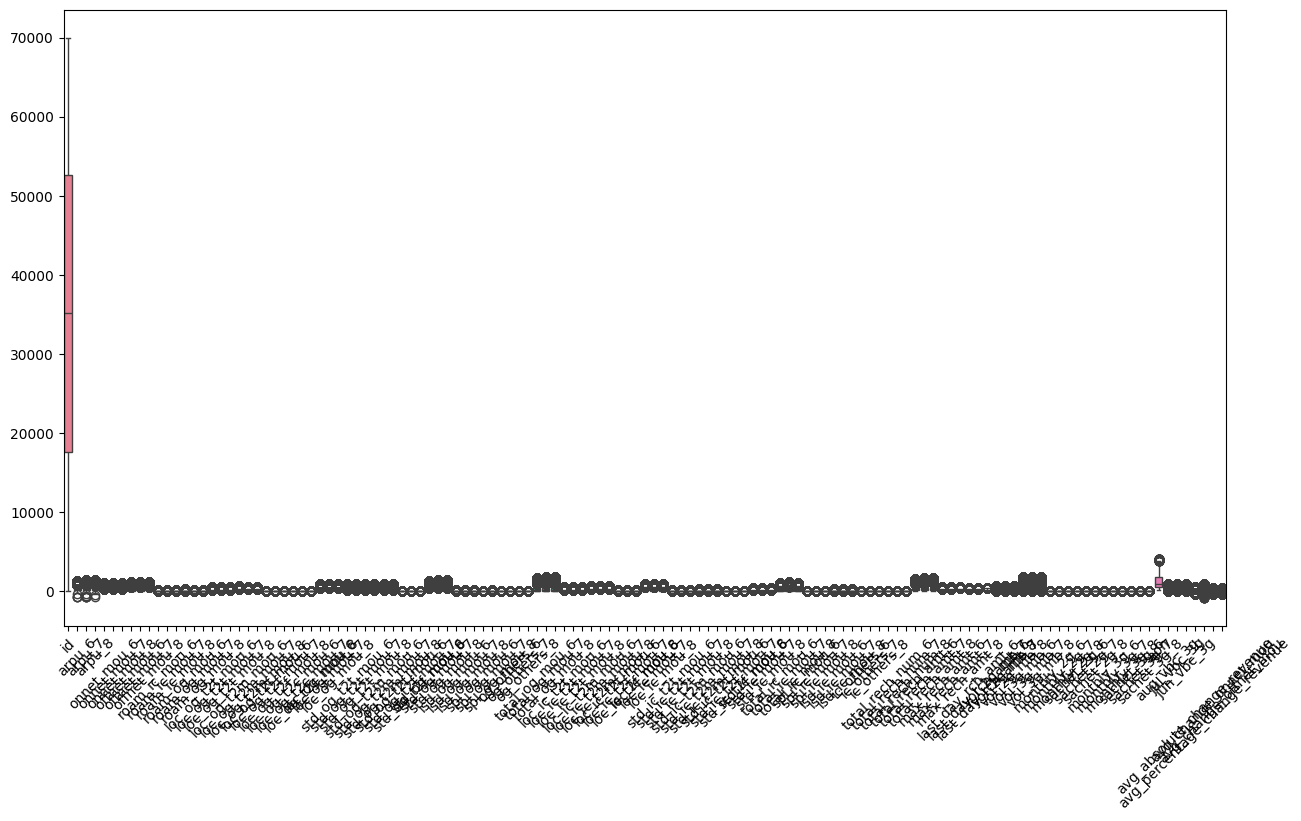

In [117]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.4 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [118]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

In [119]:
X_train_filtered1.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
60564  60564  140.092  255.518  174.689         8.93        23.53   
9704    9704  252.369  257.830   86.027       293.64       186.71   
63089  63089  416.623  397.056  381.633       429.66       480.31   
9347    9347  333.276  293.960  302.107        18.33        26.01   
17082  17082  306.193  309.776  377.208       148.41       125.73   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
60564         3.44        114.01        283.11        240.63  ...   
9704         48.68         60.79        315.74        142.13  ...   
63089       395.69        382.14        283.83        373.06  ...   
9347         22.08        527.23        539.63        386.93  ...   
17082        94.29        240.58        183.36        308.33  ...   

       sachet_3g_7  sachet_3g_8     aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
60564          0.0          0.0   263.0         0.0         0.0         0.0   
9704           0.0          0.0   678.0         0.0         0.0         0.0   
63089          0.0          0.0  1040.0         0.0         0.0         0.0   
9347           0.0          0.0   989.0         0.0         0.0         0.0   
17082          0.0          0.0  1632.0         0.0         0.0         0.0   

       avg_absolute_change_revenue  avg_percentage_change_revenue  \
60564                      17.2985                       0.253798   
9704                      -83.1710                      -0.322352   
63089                     -17.4950                      -0.042905   
9347                      -15.5845                      -0.045127   
17082                      35.5075                       0.114691   

       avg_change_onnet_mou  avg_change_offnet_mou  
60564                -2.745                 63.310  
9704               -122.480                 40.670  
63089               -16.985                 -4.540  
9347                  1.875                -70.150  
17082               -27.060                 33.875  

[5 rows x 129 columns]

<Axes: >

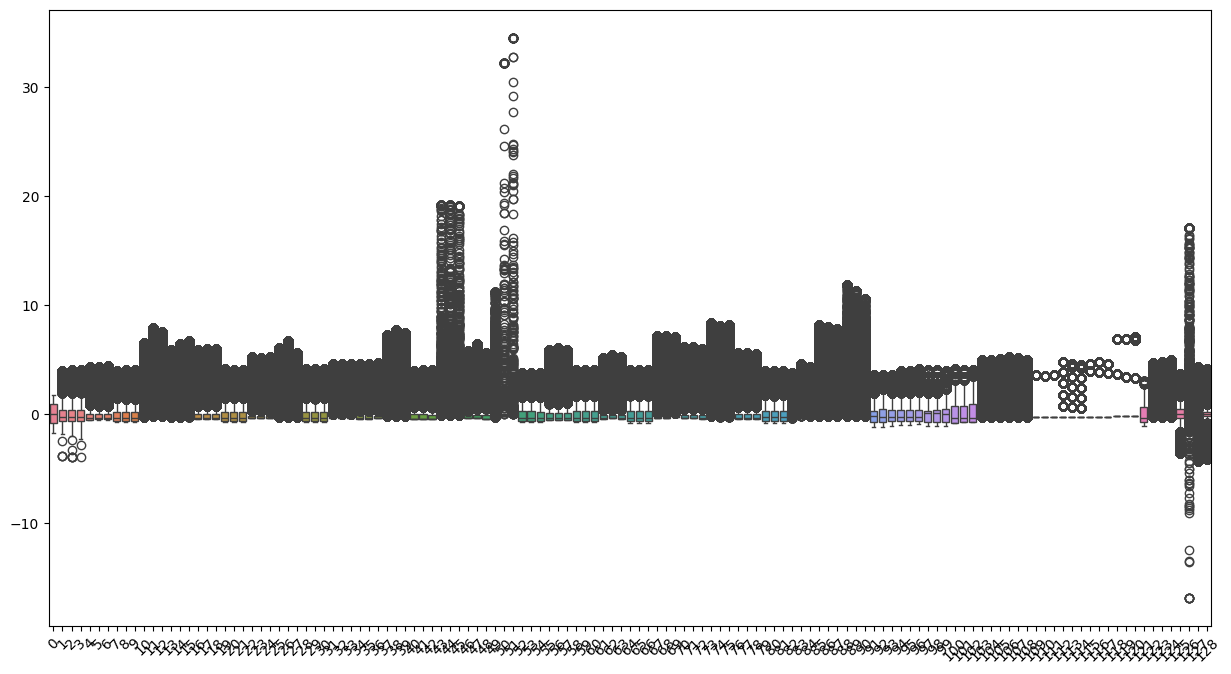

In [120]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2))

In [121]:
updated_cols = X_train_filtered.columns


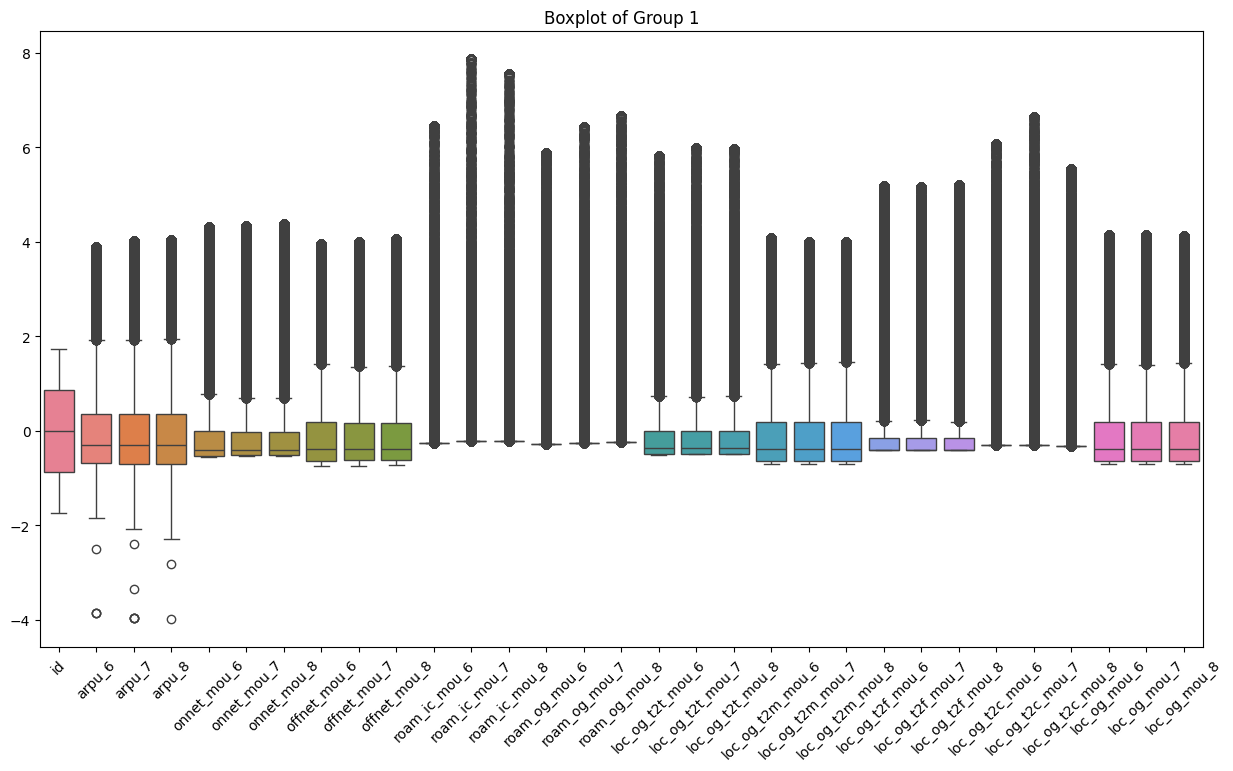

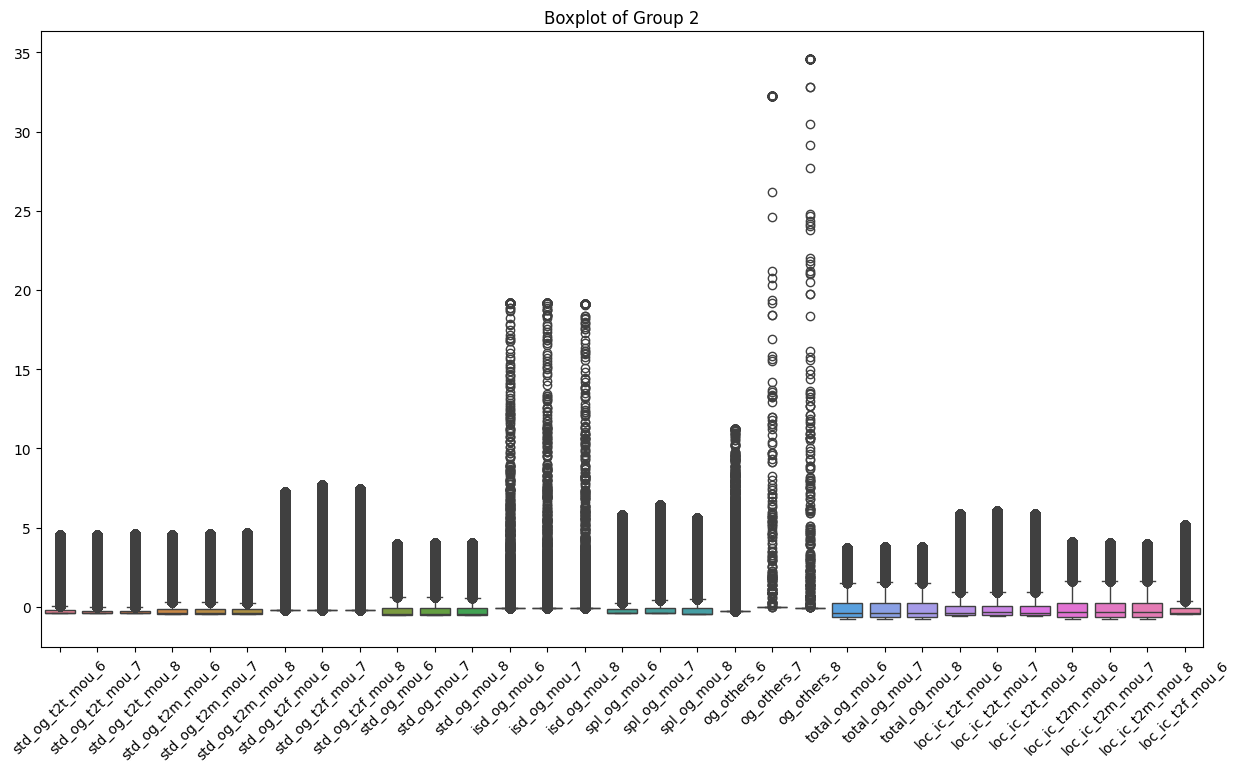

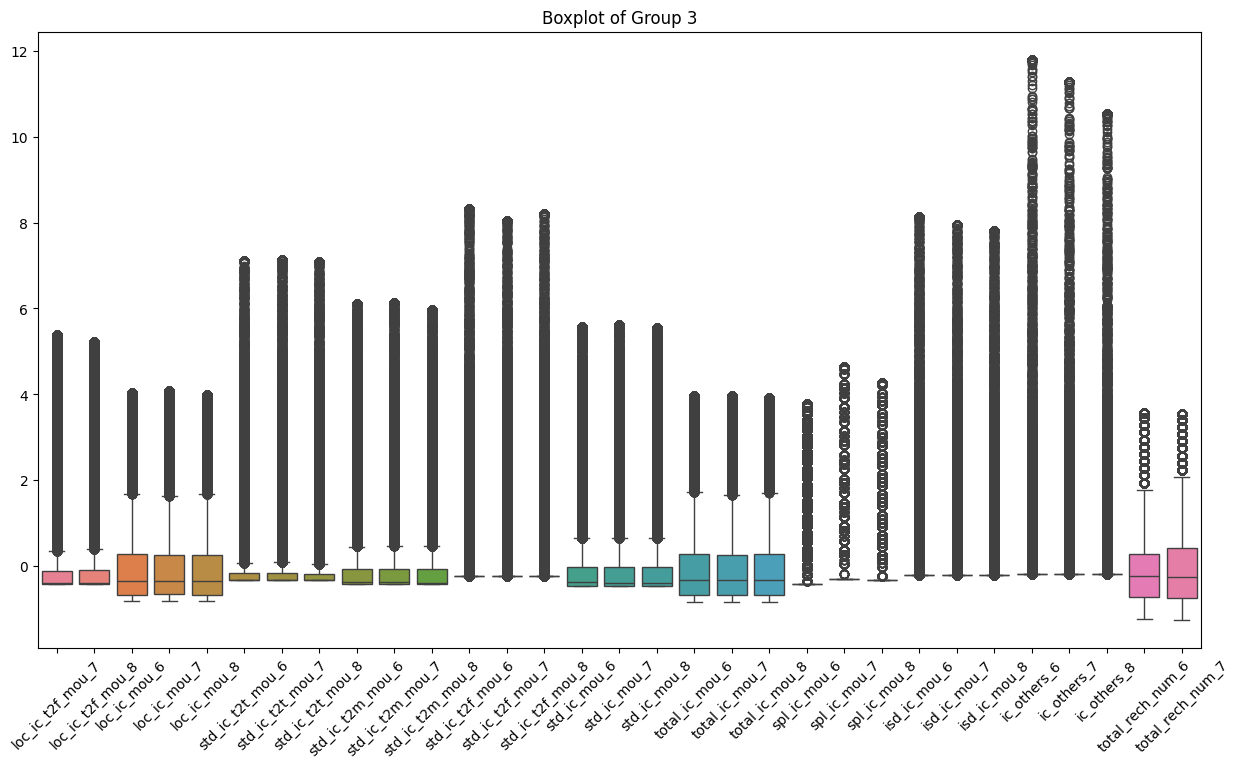

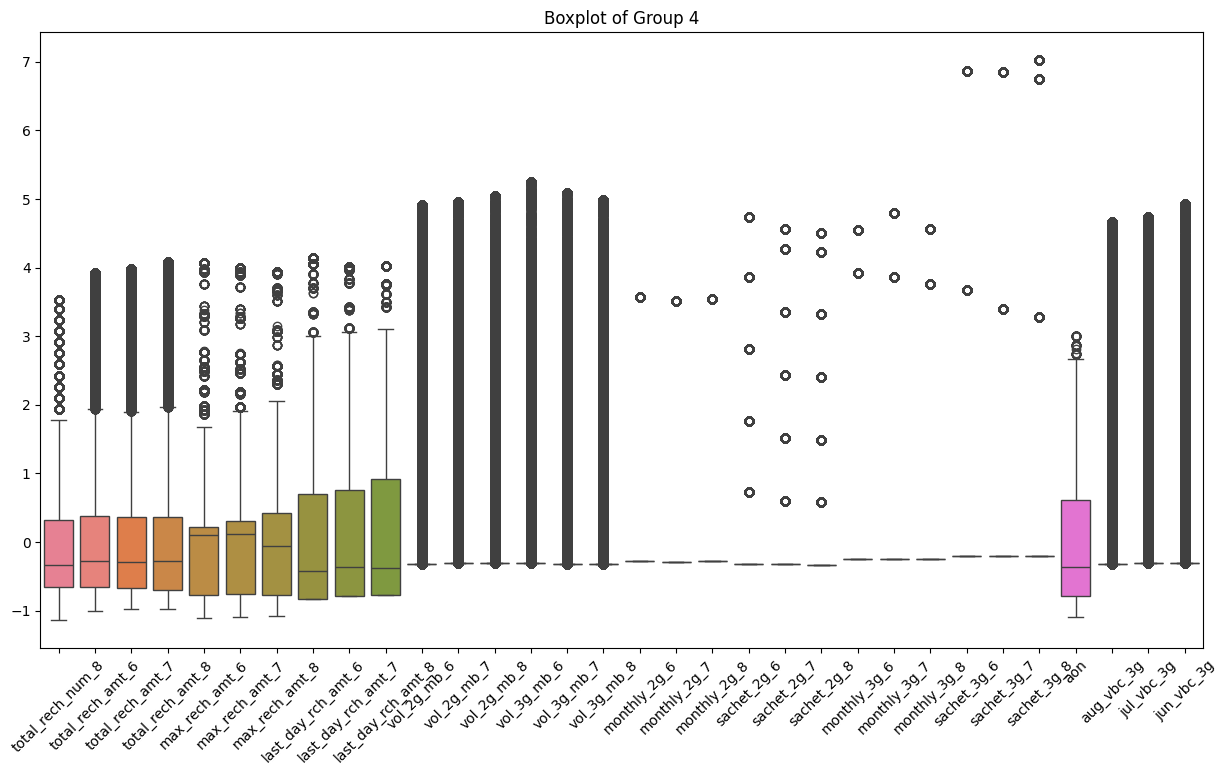

In [122]:
# Convert X_train_filtered2 to a DataFrame with column names from new_vars
X_train_filtered2_df = pd.DataFrame(X_train_filtered2, columns=updated_cols)

# Define the number of groups
num_groups = 4
columns_per_group = len(new_vars) // num_groups

# Create separate boxplots for each group of columns
for i in range(num_groups):
    # Select the subset of columns for this group
    start = i * columns_per_group
    end = (i + 1) * columns_per_group if i != num_groups - 1 else len(new_vars)
    group_columns = new_vars[start:end]
    
    # Create the boxplot for the current group by selecting only the relevant columns
    plt.figure(figsize=(15, 8))
    plt.xticks(rotation=45)
    sns.boxplot(data=X_train_filtered2_df[group_columns])
    plt.title(f"Boxplot of Group {i + 1}")
    plt.show()

### 4.5 Cross Correlation

<Axes: >

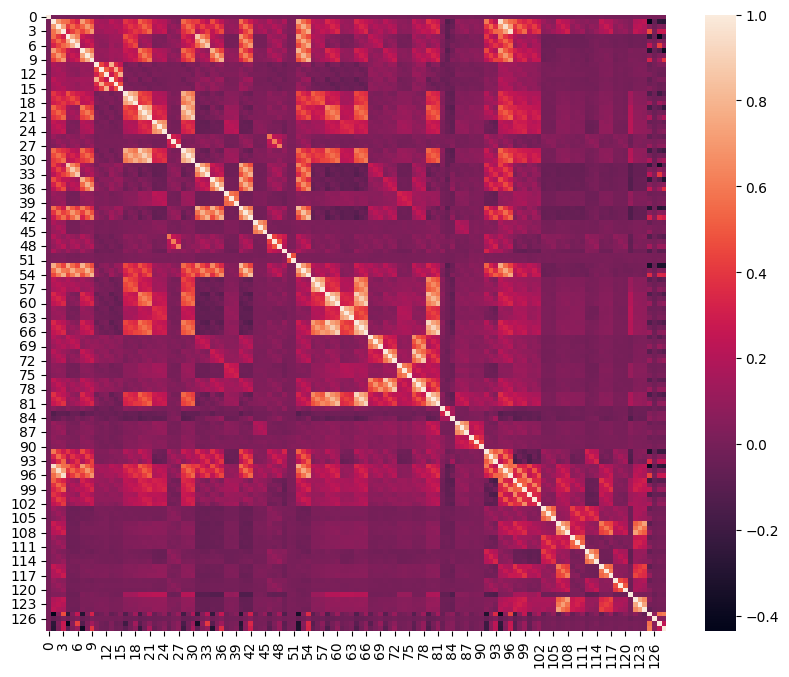

In [124]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2).corr())

In [125]:
# It appears that there is a range of correlation between the variables. This is less of an issue with PCA.

## Model 1. RFE with Logistic Regression 

#### Selecting Features with RFE

In [126]:
print(X_train_filtered2.shape)
print(y_train.shape)


(55999, 129)
(55999,)


In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

logreg = LogisticRegression()
rfe = RFE(estimator=logreg, n_features_to_select=13)  # specify n_features_to_select as a keyword argument
rfe = rfe.fit(X_train_filtered2, y_train)
print(rfe.support_)  # Print the boolean results


[False False False False False False False  True False  True False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
  True False False  True False  True  True False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False  True False False
 False False False False False False  True False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False  True]


In [128]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('id', False, 117),
 ('arpu_6', False, 85),
 ('arpu_7', False, 10),
 ('arpu_8', False, 2),
 ('onnet_mou_6', False, 41),
 ('onnet_mou_7', False, 63),
 ('onnet_mou_8', False, 68),
 ('offnet_mou_6', True, 1),
 ('offnet_mou_7', False, 37),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 116),
 ('roam_ic_mou_7', False, 74),
 ('roam_ic_mou_8', False, 103),
 ('roam_og_mou_6', False, 46),
 ('roam_og_mou_7', False, 65),
 ('roam_og_mou_8', False, 15),
 ('loc_og_t2t_mou_6', False, 33),
 ('loc_og_t2t_mou_7', False, 36),
 ('loc_og_t2t_mou_8', False, 7),
 ('loc_og_t2m_mou_6', False, 34),
 ('loc_og_t2m_mou_7', False, 83),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 47),
 ('loc_og_t2f_mou_7', False, 106),
 ('loc_og_t2f_mou_8', False, 89),
 ('loc_og_t2c_mou_6', False, 97),
 ('loc_og_t2c_mou_7', False, 96),
 ('loc_og_t2c_mou_8', False, 108),
 ('loc_og_mou_6', False, 32),
 ('loc_og_mou_7', False, 28),
 ('loc_og_mou_8', False, 8),
 ('std_og_t2t_mou_6', False, 45),
 ('std_og_t2t_mou

In [129]:
col = X_train.columns[rfe.support_]

In [130]:
# Variables selected by RFE 
print(col)

Index(['offnet_mou_6', 'offnet_mou_8', 'loc_og_t2m_mou_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_7', 'loc_ic_mou_8',
       'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'vol_2g_mb_8',
       'avg_change_offnet_mou'],
      dtype='object')


##### Assessing the model with StatsModels

In [131]:
# plt.figure(figsize=(10,8))
# sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

In [132]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(C=1e9)
#logsk.fit(X_train[col], y_train)
logsk.fit(X_train_filtered2, y_train)

LogisticRegression(C=1000000000.0)

In [134]:
#Comparing the model with StatsModels
#logm4 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
import statsmodels.api as sm
logm4 = sm.GLM(y_train,(sm.add_constant(X_train_filtered2)), family = sm.families.Binomial())
modres = logm4.fit()
logm4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                55999
Model:                            GLM   Df Residuals:                    55869
Model Family:                Binomial   Df Model:                          129
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11423.
Date:                Wed, 20 Nov 2024   Deviance:                       22846.
Time:                        05:44:27   Pearson chi2:                 2.24e+07
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2205
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3314      0.052    -83.715      0.000      -4.433      -4.230
x1             0.0027      0.017      0.159      0.874      -0.031       0.036
x2             0.0443      0.120      0.370      0.712      -0.191       0.279
x3             0.3116      0.075      4.179      0.000       0.165       0.458
x4             0.6114      0.134      4.576      0.000       0.350       0.873
x5            -0.2921      0.136     -2.142      0.032      -0.559      -0.025
x6            -0.0776      0.137     -0.566      0.571      -0.346       0.191
x7             0.0304      0.169      0.180      0.857      -0.300       0.361
x8             0.3823      0.128      2.978      0.003       0.131       0.634
x9             0.0543      0.135      0.402      0.688      -0.211       0.319
x10           -1.1475      0.158     -7.258      0.000      -1.457      -0.838
x11           -0.0038      0.028     -0.139      0.890      -0.058       0.050
x12            0.0269      0.026      1.034      0.301      -0.024       0.078
x13            0.0120      0.024      0.507      0.612      -0.034       0.058
x14            0.0613      0.031      1.989      0.047       0.001       0.122
x15            0.0415      0.027      1.533      0.125      -0.012       0.095
x16            0.2165      0.027      8.090      0.000       0.164       0.269
x17           -0.1662      0.112     -1.490      0.136      -0.385       0.052
x18            0.2293      0.137      1.672      0.094      -0.039       0.498
x19           -0.7340      0.187     -3.927      0.000      -1.100      -0.368
x20           -0.1839      0.161     -1.143      0.253      -0.499       0.132
x21            0.1049      0.195      0.537      0.591      -0.278       0.488
x22           -0.8619      0.261     -3.303      0.001      -1.373      -0.350
x23           -0.0696      0.037     -1.903      0.057      -0.141       0.002
x24            0.0030      0.044      0.069      0.945      -0.083       0.089
x25           -0.0468      0.051     -0.924      0.355      -0.146       0.052
x26           -0.0169      0.023     -0.749      0.454      -0.061       0.027
x27            0.0146      0.025      0.587      0.557      -0.034       0.063
x28            0.0080      0.032      0.247      0.805      -0.055       0.071
x29            0.3775      0.254      1.488      0.137      -0.120       0.875
x30           -0.4125      0.302     -1.368      0.171      -1.004       0.179
x31            1.2929      0.389      3.321      0.001       0.530       2.056
x32            0.1152      0.108      1.070      0.285      -0.096       0.326
x33            0.1529      0.131      1.166      0.244      -0.104       0.410
x34           -0.2720      0.164     -1.658      0.097      -0.593       0.050
x35            0.2019      0.101      1.997      0.046       0.004       0.400
x3

In [135]:
X_test.describe

<bound method NDFrame.describe of           id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
11303  11303    1.750  147.001  250.991         0.00         6.89   
48243  48243  127.141   89.806   59.664        11.51        29.26   
64222  64222  502.803  479.401  570.258        60.13        42.51   
39642  39642  990.438  441.006  983.856       321.26        94.09   
42036  42036  271.548  274.297  360.299        64.56        68.23   
...      ...      ...      ...      ...          ...          ...   
24431  24431  143.596  176.744    0.000        65.18        19.73   
60082  60082  181.010  101.121  160.171       134.19        90.06   
14248  14248  213.950  278.410  320.315        51.56        80.49   
28241  28241  128.748  128.723  130.432         0.00         0.00   
32990  32990  390.690  190.837  191.831        47.33        35.74   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
11303        28.36          0.46        185.81        369.61  ...   

In [136]:
# X_test[col].shape
# #res = modres.predict(X_test[col])

### Making Predictions with RFE

In [137]:
# Predicted probabilities
y_pred = logsk.predict_proba(X_test_filtered)
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
# Let's see the head
y_pred_1.head()

1
0  3.075361e-109
1   9.781147e-61
2   0.000000e+00
3   1.000000e+00
4  3.404417e-281

In [138]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

churn_probability
11303                  0
48243                  0
64222                  0
39642                  0
42036                  0

In [139]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
# Rearranging the columns using reindex
y_pred_final = y_pred_final.reindex(columns=['CustID', 'churn_probability', 'Churn_Prob'])

# Let's see the head of y_pred_final
y_pred_final.head()


CustID  churn_probability     Churn_Prob
0   11303                  0  3.075361e-109
1   48243                  0   9.781147e-61
2   64222                  0   0.000000e+00
3   39642                  0   1.000000e+00
4   42036                  0  3.404417e-281

In [140]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)
# Let's see the head
y_pred_final.head()

CustID  churn_probability     Churn_Prob  predicted
0   11303                  0  3.075361e-109          0
1   48243                  0   9.781147e-61          0
2   64222                  0   0.000000e+00          0
3   39642                  0   1.000000e+00          1
4   42036                  0  3.404417e-281          0

### RFE Model Evaluation

In [141]:
from sklearn import metrics

In [142]:
print(y_pred_final.isnull().sum())


CustID               0
churn_probability    0
Churn_Prob           0
predicted            0
dtype: int64


In [143]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn_probability , y_pred_final.predicted )
confusion

array([[10678,  1879],
       [  874,   569]])

In [144]:
#Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.churn_probability, y_pred_final.predicted)

0.8033571428571429

In [146]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_pred_final['churn_probability'], y_pred_final['predicted'])
recall = recall_score(y_pred_final['churn_probability'], y_pred_final['predicted'])
f1 = f1_score(y_pred_final['churn_probability'], y_pred_final['predicted'])

print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.2324
Recall (Sensitivity): 0.3943
F1-Score: 0.2925


### Model 2. Logistic Regression and PCA 

In [149]:


# converting to data frame, in order to extract columns
X_train_filtered2_df = pd.DataFrame(X_train_filtered2)


In [150]:
from sklearn.decomposition import PCA

<Axes: >

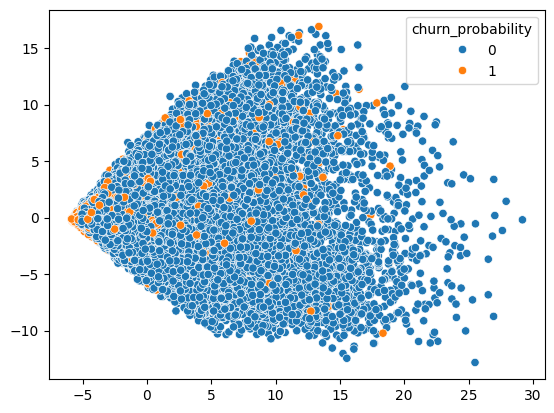

In [151]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

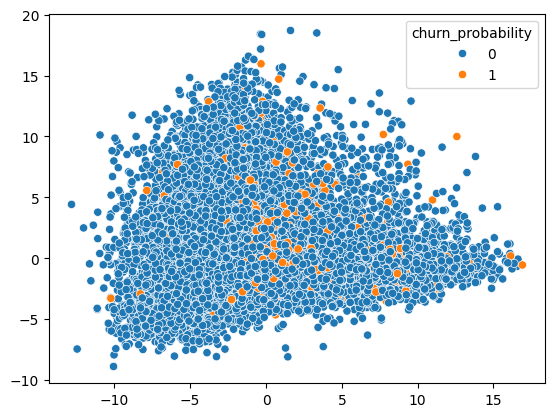

In [152]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

#### Feature engineering and selection

<BarContainer object of 129 artists>

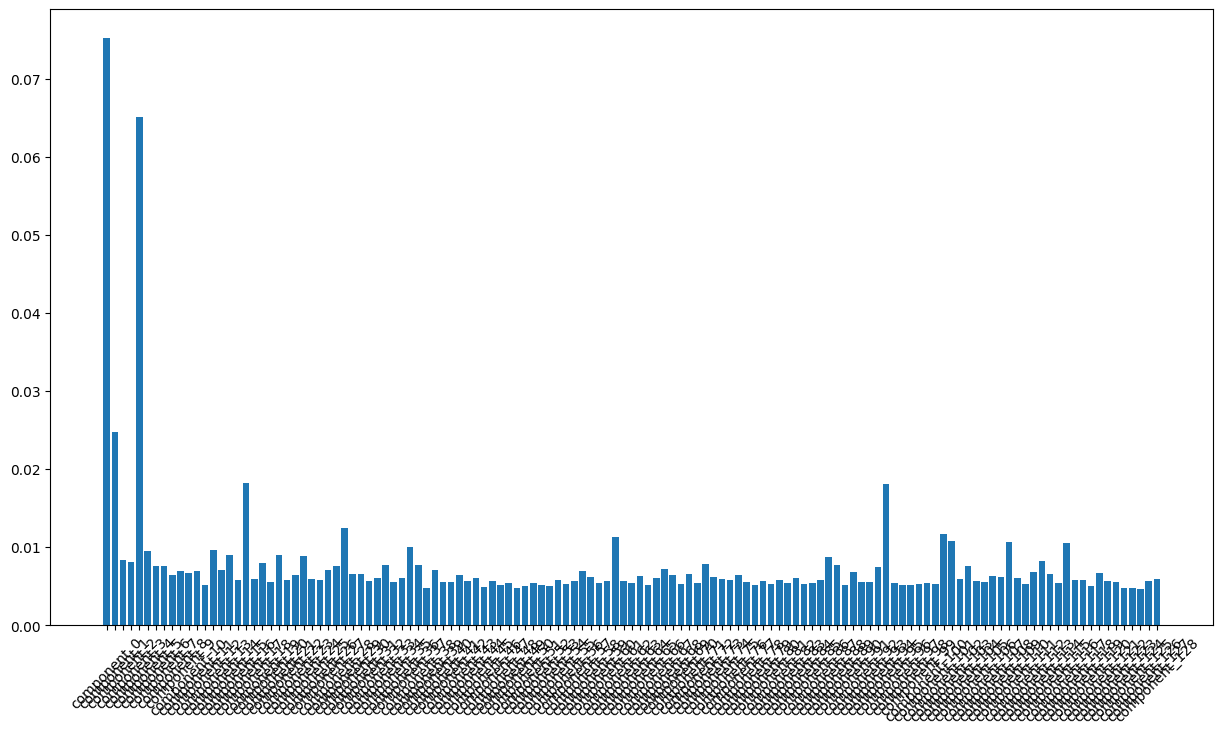

In [153]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({
    'col': ['component_' + str(i) for i in range(len(rf.feature_importances_))],
    'importance': rf.feature_importances_
})


plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

#### Adding Logistic Regression Model

In [154]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [155]:
lr.score(pca_components[:,:2], y_train)

0.8984089001589314

In [156]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [157]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [158]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [159]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.8985517598528545


In [160]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8972857142857142


In [161]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[50234,    76],
       [ 5605,    84]])

In [162]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[12538,    19],
       [ 1419,    24]])

In [163]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.5581395348837209

In [164]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.016632016632016633

### Model 3. SMOTE, Logistic Regression and PCA 

<Axes: xlabel='churn_probability', ylabel='Count'>

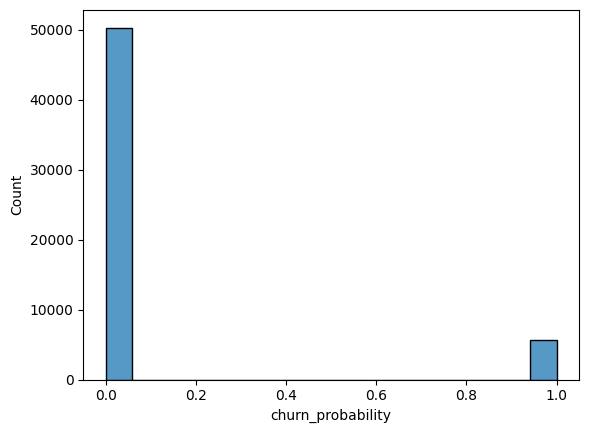

In [165]:
#Distribution for the churn probability
sns.histplot(y_train)

In [166]:
print("Shape of X_train_filtered2:", X_train_filtered2.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train_filtered2: (55999, 129)
Shape of y_train: (55999,)


In [167]:
from imblearn.over_sampling import SMOTE

In [168]:
smt = SMOTE(random_state=2)
X_train_filtered2_smote, y_train_smote = smt.fit_resample(X_train_filtered2, y_train)

<Axes: xlabel='churn_probability', ylabel='Count'>

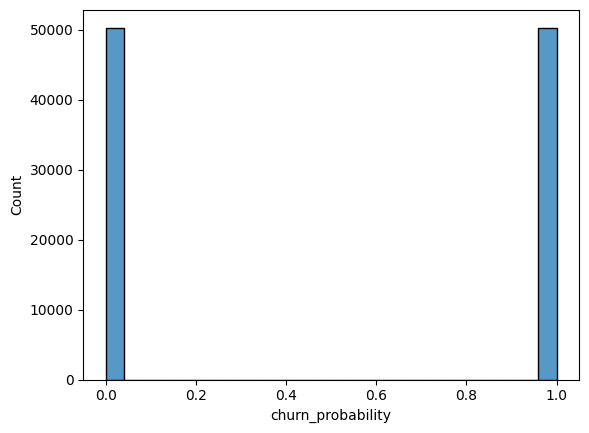

In [169]:
#Distribution for the churn probability
sns.histplot(y_train_smote)

### PCA on smote values

<Axes: >

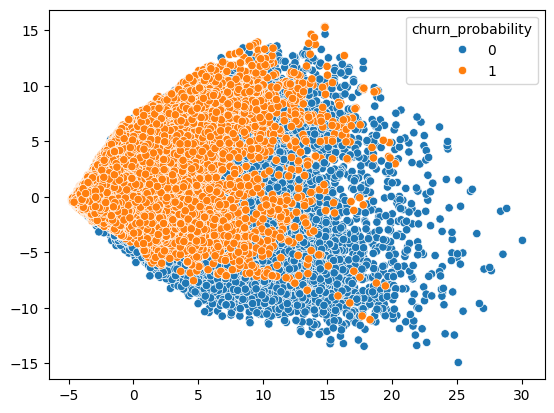

In [170]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2_smote)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train_smote)

<Axes: >

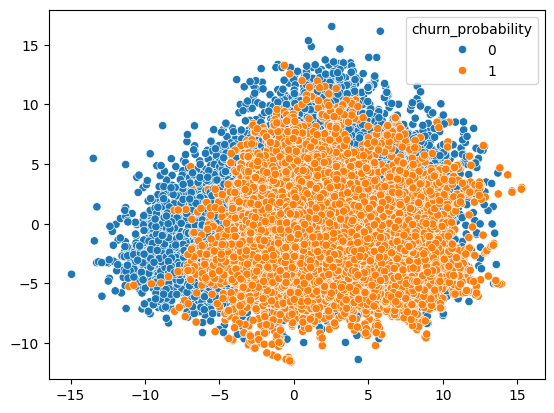

In [171]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train_smote)

<BarContainer object of 129 artists>

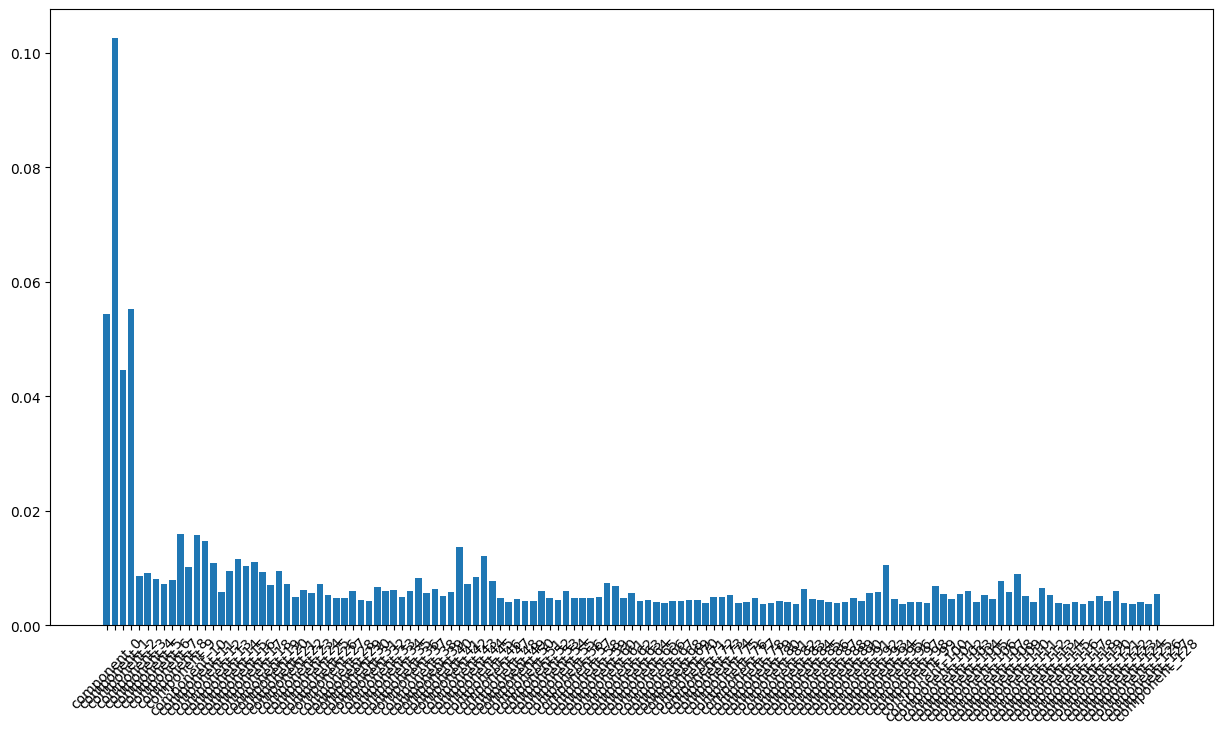

In [172]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train_smote)

feature_importances = pd.DataFrame({
    'col': ['component_' + str(i) for i in range(len(rf.feature_importances_))],
    'importance': rf.feature_importances_
})


plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

#### Adding Logistic Regression Model

In [173]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train_smote)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [174]:
lr.score(pca_components[:,:2], y_train_smote)

0.7518684158219042

### Model 4. PCA, SMOTE and GridSearchCV

In [199]:
from sklearn.tree import DecisionTreeClassifier

# Create and fit the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_filtered2, y_train)

dt = DecisionTreeClassifier(random_state=42)

In [200]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=25)
smote = SMOTE(random_state=2)

In [201]:
from imblearn.pipeline import make_pipeline
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    dt
)

In [202]:
# Create the parameter grid based on the results of random search 
params = {
    'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [5, 10, 20, 50, 100],
}

In [203]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [ ]:

# Fit the GridSearchCV
grid_search.fit(X_train_filtered2, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [ ]:
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Predict on train set using the best model
y_train_pred = grid_search.predict((X_train_filtered2)

# Predict on validation set using the best model
y_val_pred = grid_search.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
# Confusion Matrix
cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:\n")
print(cm)

# Extract TP, FP, TN, FN from the confusion matrix
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

In [ ]:


# Classification Metrics
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)  # Same as sensitivity
f1 = f1_score(y_train, y_train_pred)
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity manually calculated
false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nClassification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"False Positive Rate: {false_positive_rate:.4f}")

### Model 5. PCA and GridSearchCV (No SMOTE)

## Summary

### Technical Synopsis: Model Selection for Telecom Churn Prediction

This case study explores various machine learning models for predicting telecom churn, with a focus on identifying the most effective model based on sensitivity. The models tested include:

1. Logistic Regression (LR) with Recursive Feature Elimination (RFE)
2. Logistic Regression (LR) with hyperparameter tuning
3. Principal Component Analysis (PCA) applied to various classifiers
4. Decision Tree, Random Forest classifiers with hyperparameter tuning and PCA

Key findings from the experimentation include:

- Logistic Regression with PCA consistently demonstrated the highest sensitivity in both the training and validation sets, outperforming other models.
- Other models, despite showing promising accuracy during training, exhibited signs of **overfitting** with poor performance on the test set.

Given the business context of telecom churn, where minimizing false negatives (churned customers) is critical, **sensitivity** is prioritized as the key performance metric. Therefore, **Logistic Regression with PCA** is determined to be the most suitable model for predicting telecom churn, providing the best balance of model performance and interpretability.

### Conclusion:
Logistic Regression with PCA is recommended as the final model for churn prediction due to its superior sensitivity in both the training and validation phases, making it the optimal choice for minimizing churn in a telecom context.

In [190]:
columns_having_null = X_train_filtered2_df.columns[X_train_filtered2.isnull().sum()>0]
print(columns_having_null)

AttributeError: 'numpy.ndarray' object has no attribute 'isnull'

In [79]:
X_train_filtered[columns_having_null] =X_train_filtered[columns_having_null].fillna(0)
print(X_train_filtered.isnull().sum())


id                               0
arpu_6                           0
arpu_7                           0
arpu_8                           0
onnet_mou_6                      0
                                ..
jun_vbc_3g                       0
avg_absolute_change_revenue      0
avg_percentage_change_revenue    0
avg_change_onnet_mou             0
avg_change_offnet_mou            0
Length: 129, dtype: int64


In [80]:
pca.fit(X_train_filtered)

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [42]:
#Segregating the train data for high value customers
## This needs to be done before Scaling ....
X_train_filtered.columns

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=125)

In [43]:
X_train_filtered.shape

(55999, 125)

In [44]:
X_train_filtered.shape

(55999, 125)

In [45]:
y_train.value_counts()

0    50302
1     5697
Name: churn_probability, dtype: int64

In [46]:
y_test.value_counts()

0    12565
1     1435
Name: churn_probability, dtype: int64

<Axes: xlabel='churn_probability', ylabel='Count'>

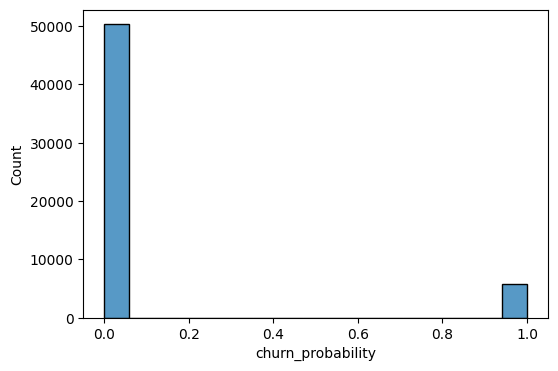

In [47]:
#Distribution for the churn probability
plt.figure(figsize=(6, 4))
sns.histplot(y_train)

In [50]:
from imblearn.over_sampling import SMOTE

In [52]:
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train_filtered2, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)


(100604, 125)
(100604,)


### 4.5 SMOTE to fix imbalance in chun probability